# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

Constantinos Mavrommatis and Matt Carre

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [1]:
# Install imbalanced-learn for undersampling
#!pip install imblearn

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# sklearn modules
import sklearn
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import average_precision_score

In [2]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")

/tmp/ipykernel_16377/166865228.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv("freddiemac.csv")


# Introduction

In this report, we propose a model to predict whether a loan will default or be paid off using Freddie Mac’s Single Family Loan Level Dataset from 2017 to 2020. Our approach centers on a Random Forest classifier, an ensemble method known for its effectiveness in handling complex interactions among features, class imbalance, and data noise all crucial aspects of credit risk analysis. The dataset includes information such as borrowers FICO scores, loan-to-value ratios, interest rates, and various categorical indicators. We also incorporate details like whether the loan resides in a judicial or non-judicial foreclosure state to account for regional legal differences.

In our final configuration, the Random Forest model demonstrated notable improvements in both accuracy and recall compared to our baseline Logistic Regression. The model achieved a 73% accuracy score and, more importantly, correctly identified 95 out of 149 defaulted loans in the test set, a strong result given the high class imbalance often found in these types of datasets. This enhanced predictive performance stems from the Random Forest’s ability to evaluate a wide array of interaction effects, particularly valuable in capturing the multifaceted nature of loan default risk while simultaneously reducing overfitting through ensembling. By systematically evaluating key hyperparameters and preserving interpretability via feature importance measures, our approach ensures that the reasons behind a given loan’s risk level are transparent to stakeholders.

Additionally, we applied the model to the currently active loans to gauge which might be at high risk of default. About 91% were classified as high risk and 9% as moderate, likely due to the model’s current threshold or predictive capabilities. Adjusting this threshold based on Freddie Mac’s domain expertise could yield a more balanced risk assessment or help prioritize loans for closer monitoring.

For a financial institution like Freddie Mac, our findings offer a foundation for early risk detection and targeted intervention. By uncovering the principal drivers of default, such as high debt-to-income ratios or unfavorable loan terms, decision-makers can implement strategies—like underwriting policies or borrower support initiatives to mitigate potential losses. Subsequent sections detail the data preprocessing steps, the rationale for Random Forest over other algorithms, the final model’s performance metrics, and real-world applications of these insights for lending practices and regulatory compliance.

# Exploratory Data Analysis and Feature Engineering

In this section, we will be discussing the thought process that guided our selection of which features to include in the final model, that ultimately predicts if an individual will default on there loans. We also explore the data for important findings or ways to improve model selection.

First, due to the structure of the dataset where missing information for different columns is presented in a non-standardized format using various numerical error codes, we had to map these error codes so that we could convert them into null values for the later steps of our feature engineering, allowing us to clearly evaluate the data without any skewness.

In [3]:
# Create a dictionary mapping for error codes
error_map = {
    "fico": 9999,         
    "flag_fthb": 9,
    "cnt_units": 99,
    "occpy_sts": 9,
    "prop_type": 99,
    "mi_pct": [999],        
    "dti": 999,            
    "cnt_borr": 99,
    "mi_cancel_ind": "7",
    "property_val": 9,
    "channel": 9
}

# Replace the error values in each relevant column with NaN
for col, error_value in error_map.items():
    if col in d.columns:
        d[col] = d[col].replace(error_value, np.nan)

Subsequently, Table 1 summarizes the data types and the null counts in each column. Columns with int64 and float64 are continuous features, whereas object types are categorical features, this distinction is crucial for the preprocessing of the model pipeline, because different features require different imputation or encoding methods in our pipeline. Moreover, the table reveals that certain columns contain missing data and need an imputation strategy to fill the missing values. That is because if we dropped rows with missing data, we would be losing data equivalent to the null count percentage, which is undesirable with further complications of scikit-learn not being able to handle missing values well.

In [4]:
# Convert columns to appropriate dtypes before summarizing
d['property_val'] = d['property_val'].astype('object')
d['cnt_units'] = d['cnt_units'].astype('object')

# Create a summary DataFrame of data types and missing values
summary = pd.DataFrame({
    'Data Type': d.dtypes,
    'Non-Null Count': d.count(),
    'Null Count': d.isna().sum(),
    'Null Count Percentage': round((d.isna().sum() / len(d)) * 100)
})
print("\nTable 1: A summary of the dataset, showing data types, non-null counts, and missing values.\n")
display(summary)


Table 1: A summary of the dataset, showing data types, non-null counts, and missing values.



,Data Type,Non-Null Count,Null Count,Null Count Percentage
fico,float64,199959,41,0.0
dt_first_pi,int64,200000,0,0.0
flag_fthb,object,200000,0,0.0
dt_matr,int64,200000,0,0.0
cd_msa,float64,181072,18928,9.0
mi_pct,float64,199999,1,0.0
cnt_units,object,200000,0,0.0
occpy_sts,object,200000,0,0.0
cltv,int64,200000,0,0.0
dti,float64,197588,2412,1.0


Furthermore, our dataset included multiple columns that were redundant, for example two "ID" (id_loan, id_loan_rr) and two "Date" (dt_first_pi, dt_matr) columns, as well as several pieces of information that did not seem to meaningfully improve our model’s ability to predict loan outcomes. Other variables such as servicer_name, seller_name, cnt_borr, and program_ind were also removed because their contributions were either redundant or already captured by stronger predictors in the dataset. Additionally, cd_msa and flag_sc where removed due to the high null count that they presented. 

In [5]:
# List of columns to drop as identified during initial exploration
features_to_drop = [
    "dt_first_pi",
    "dt_matr",
    "zipcode", 
    "id_loan",
    "servicer_name",
    "id_loan_rr",
    "program_ind",
    "io_ind",
    "prod_type",
    "ppmt_pnlty",
    "seller_name",
    "cnt_borr",
    "rr_ind",
    "cd_msa", #mention
    "loan_status",
    "mi_cancel_ind",
    "cnt_units",
    "flag_sc" #mention
]

On the other hand, an interesting piece of information was the state code, which captures geographical differences but did not initially improve performance. However, this does not imply that location is unimportant; rather, it may need to be combined with more granular data that is not present in our dataset to reveal a meaningful effect. Thus, through additional research, information about states’ judicial foreclosure status was integrated and mapped to the “st” column in the hope that this transformation would enhance the model’s accuracy. Finally, in order to focus solely on defaulted and fully paid loans, we removed any active loans (those with loan_status labeled as “active”). Excluding these active loans helps ensure our model is trained only on definitive outcomes, thus refining its predictive capabilities for default versus repayment.

In [6]:
# Dictionary mapping state -> foreclosure type
foreclosure_mapping = {
    'CA': 'Non-Judicial', 'TX': 'Non-Judicial', 'FL': 'Judicial', 'IL': 'Judicial',
    'MI': 'Judicial', 'OH': 'Judicial', 'AZ': 'Non-Judicial', 'WA': 'Non-Judicial',
    'CO': 'Non-Judicial', 'GA': 'Non-Judicial', 'NC': 'Non-Judicial', 'NY': 'Judicial',
    'PA': 'Judicial', 'VA': 'Non-Judicial', 'NJ': 'Judicial', 'IN': 'Judicial',
    'MA': 'Non-Judicial', 'MN': 'Both', 'MO': 'Both', 'TN': 'Non-Judicial',
    'UT': 'Non-Judicial', 'OR': 'Non-Judicial', 'MD': 'Both', 'WI': 'Judicial',
    'SC': 'Judicial', 'NV': 'Non-Judicial', 'KY': 'Judicial', 'AL': 'Non-Judicial',
    'LA': 'Judicial', 'CT': 'Judicial', 'OK': 'Non-Judicial', 'KS': 'Judicial',
    'IA': 'Judicial', 'ID': 'Non-Judicial', 'AR': 'Non-Judicial', 'NH': 'Non-Judicial',
    'NE': 'Non-Judicial', 'NM': 'Judicial', 'ME': 'Non-Judicial', 'DE': 'Judicial',
    'MS': 'Non-Judicial', 'MT': 'Non-Judicial', 'RI': 'Non-Judicial', 'HI': 'Non-Judicial',
    'WV': 'Judicial', 'ND': 'Judicial', 'DC': 'Judicial', 'SD': 'Non-Judicial',
    'VT': 'Judicial', 'AK': 'Non-Judicial', 'WY': 'Non-Judicial', 'GU': 'Judicial',
    'PR': 'Judicial', 'VI': 'Judicial'
}

# Map each row's state code to its foreclosure type
d['st'] = d['st'].map(foreclosure_mapping)

# Remove any active loans
d_no_active = d[d['loan_status'] != 'active']

# Extract features and target variable
y = d_no_active['loan_status'].copy()
X = d_no_active.drop(features_to_drop, axis=1)

# Encode 'default' vs. 'paid' with LabelEncoder
y = LabelEncoder().fit_transform(y)

Before building our model, the data was split into training and testing sets using train_test_split with a 80/20 ratio, seeded by a random state. Splitting ensures that the model learns based on training data only, avoiding any data leakage. Due to the high imbalance between defaulted and repaid loans, we employed stratification to maintain the representative distribution of the target variable.

In [7]:
# Split data into training and testing sets
rng = np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True, stratify=y, test_size = 0.2, random_state=rng)

In [8]:
# Combine X_train and y_train into a single DataFrame
train_data = X_train.copy()
train_data["loan_status"] = y_train  # Adding y_train as a column

In [9]:
# Quick checks for distribution of default vs. non-default
overall_pct = pd.Series(y).value_counts(normalize=True) * 100
train_pct = pd.Series(y_train).value_counts(normalize=True) * 100
test_pct = pd.Series(y_test).value_counts(normalize=True) * 100

# Summarize these distributions in a table
summary_table = pd.DataFrame({
    'Overall (%)': overall_pct,
    'Train (%)': train_pct,
    'Test (%)': test_pct
})

print("\nTable 2: Distribution of Non Defaults(1)/Defaults(0): Across Overall, Training, and Test Datasets.\n")

# Display the summary table.
display(summary_table)


Table 2: Distribution of Non Defaults(1)/Defaults(0): Across Overall, Training, and Test Datasets.



,Overall (%),Train (%),Test (%)
1,99.411231,99.411034,99.41202
0,0.588769,0.588966,0.58798


In preparation for exploring the data, we separate continuous and categorical features:

In [10]:
#Extraction of Numerical and Categorical Columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

The following histograms (Figure 1) display approximate counts and skew for each categorical feature, including proverty_val, which despite being numeric behaves more like a categorical predictor here. These plots also illustrate the presence of minority groups in the categorical data, which influences whether we combine them using max_categories in our one-hot encoding approach later. Most likely, we will not choose to have a limited number of categories to produce since due to the high inbalance in the data, the categories with the small number of counts might be a good performance indicator:

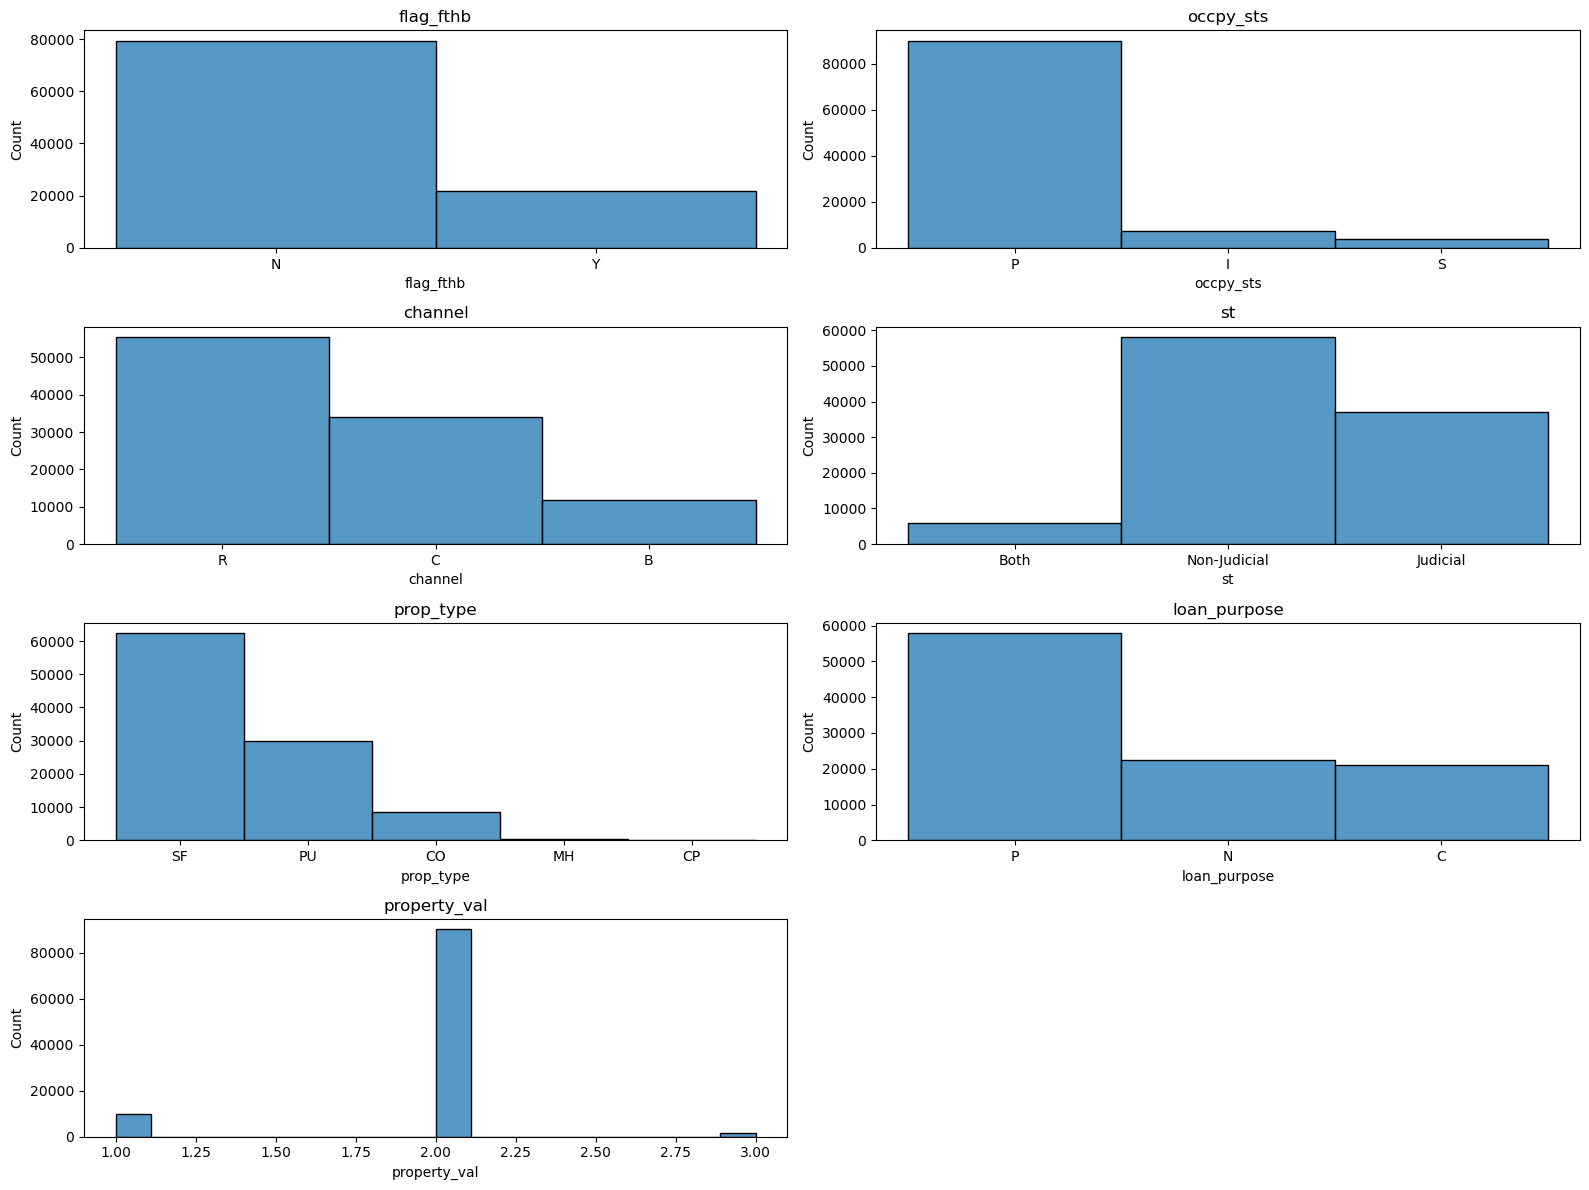

In [11]:
# Creation of subplots
fig, axes = plt.subplots(figsize=(16, 12), nrows=4, ncols=2)
axes = axes.flatten()

# Plot a countplot for each categorical feature
for i, feature in enumerate(categorical_cols):
    sns.histplot(x=X_train[feature], ax=axes[i])
    axes[i].set_title(feature)

# Turn off any extra subplots if there are fewer features than axes
for j in range(len(categorical_cols), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

*Figure 1: Count distributions for each categorical feature in X_train.*

To investigate feature relationships, we next examined how each predictor correlates with our target variable, which also helps identify features that could be removed or combined to improve generalization (Figure 2). We found no numeric features with a strong direct correlation to the loan status. However, our correlation analysis did reveal that certain features such as CLTV, LTV, and MI_PCT are highly correlated with one another. We confirm these relationships more rigorously using Pearson’s correlation test (Table 3), ensuring they are unlikely to be due to random chance. Consequently, we chose to remove some of these features to reduce redundancy and multicollinearity, thereby simplifying our model and minimizing the risk of overfitting. This approach ensures that each remaining predictor contributes unique, meaningful information.


Table 3: Correlation Analysis With P-Values

Highly correlated feature pairs (|r| >= 0.4) with P-Values:


,Feature 1,Feature 2,Correlation,P-Value
2,cltv,ltv,0.991250,0.0
1,mi_pct,ltv,0.664998,0.0
0,mi_pct,cltv,0.657505,0.0


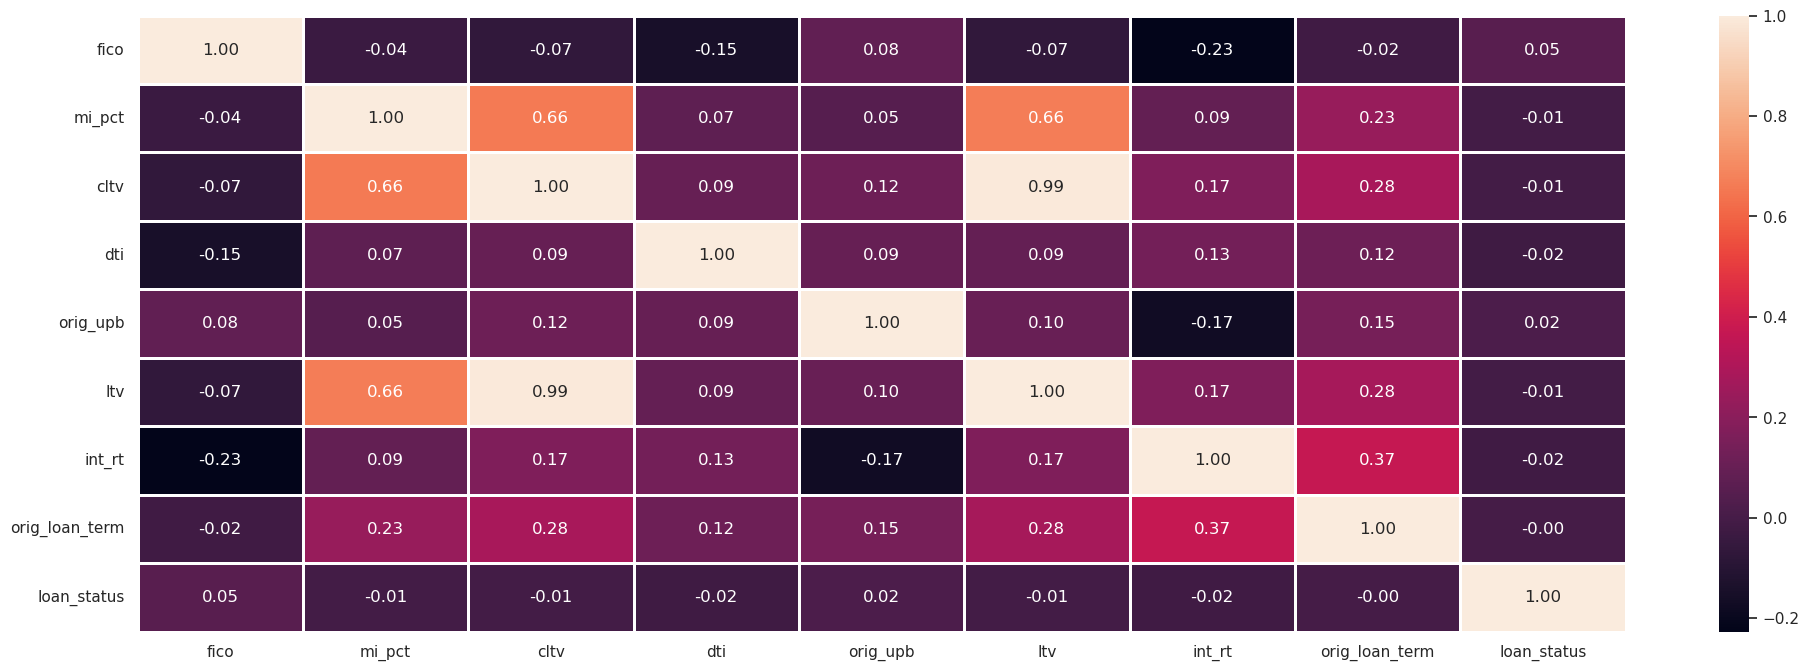

In [12]:
# Dataset without NA values
train_data_clean = train_data.dropna(subset=numerical_cols)

print("\nTable 3: Correlation Analysis With P-Values\n")
corr_cols = [col for col in numerical_cols if train_data_clean[col].nunique() > 5]

# List to store pairs of highly correlated features along with their p-values
high_corr_pairs = []
for i in range(len(corr_cols)):
    for j in range(i+1, len(corr_cols)):
        x = train_data_clean[corr_cols[i]]
        y = train_data_clean[corr_cols[j]]
        r, p_value = pearsonr(x, y)  # Computes Pearson correlation and p-value
        if abs(r) >= 0.4:
            high_corr_pairs.append((corr_cols[i], corr_cols[j], r, p_value))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation', 'P-Value'])
high_corr_df = high_corr_df.sort_values(by='Correlation', ascending=False)

print("Highly correlated feature pairs (|r| >= 0.4) with P-Values:")
if len(high_corr_df) > 0:
    display(high_corr_df)
else:
    print("No feature pairs with correlation >= 0.4 found.")

# Correlation Heatmap
sns.set(rc={'figure.figsize': (24, 8)})
sns.heatmap(data=train_data_clean.corr(numeric_only=True), annot=True, fmt=".2f", linewidths=2)
plt.show()

*Figure 2: Correlation heatmap of continuous variables in train_data.*

Following, Table 4 is comparing the mean values across the numerical features and loan status. The goal of this analysis is to determine whether there is a clear differentiation between loans that default and those that are fully paid based on key financial metrics.

In [13]:
print("\nTable 4: Mean Values Of Numerical Features By Loan Status\n")
# Compute mean values of each numeric feature, grouped by loan_status
feature_by_status = pd.DataFrame()
for col in numerical_cols:
    try:
        feature_by_status[col] = train_data_clean.groupby('loan_status')[col].mean()
    except:
        pass

display(feature_by_status)


Table 4: Mean Values Of Numerical Features By Loan Status



,fico,mi_pct,cltv,dti,orig_upb,ltv,int_rt,orig_loan_term
loan_status,,,,,,,,
0,717.900533,9.580817,78.561279,38.239787,229085.257549,78.250444,4.433309,334.188277
1,749.492721,7.822395,76.037697,35.188773,259992.260186,75.777801,4.281966,332.378058


Next, we created Q-Q plots (Figure 3) to test normality across numerical features. Most appear approximately linear, so no immediate transformations (like log or square-root) were applied before developing our initial models.

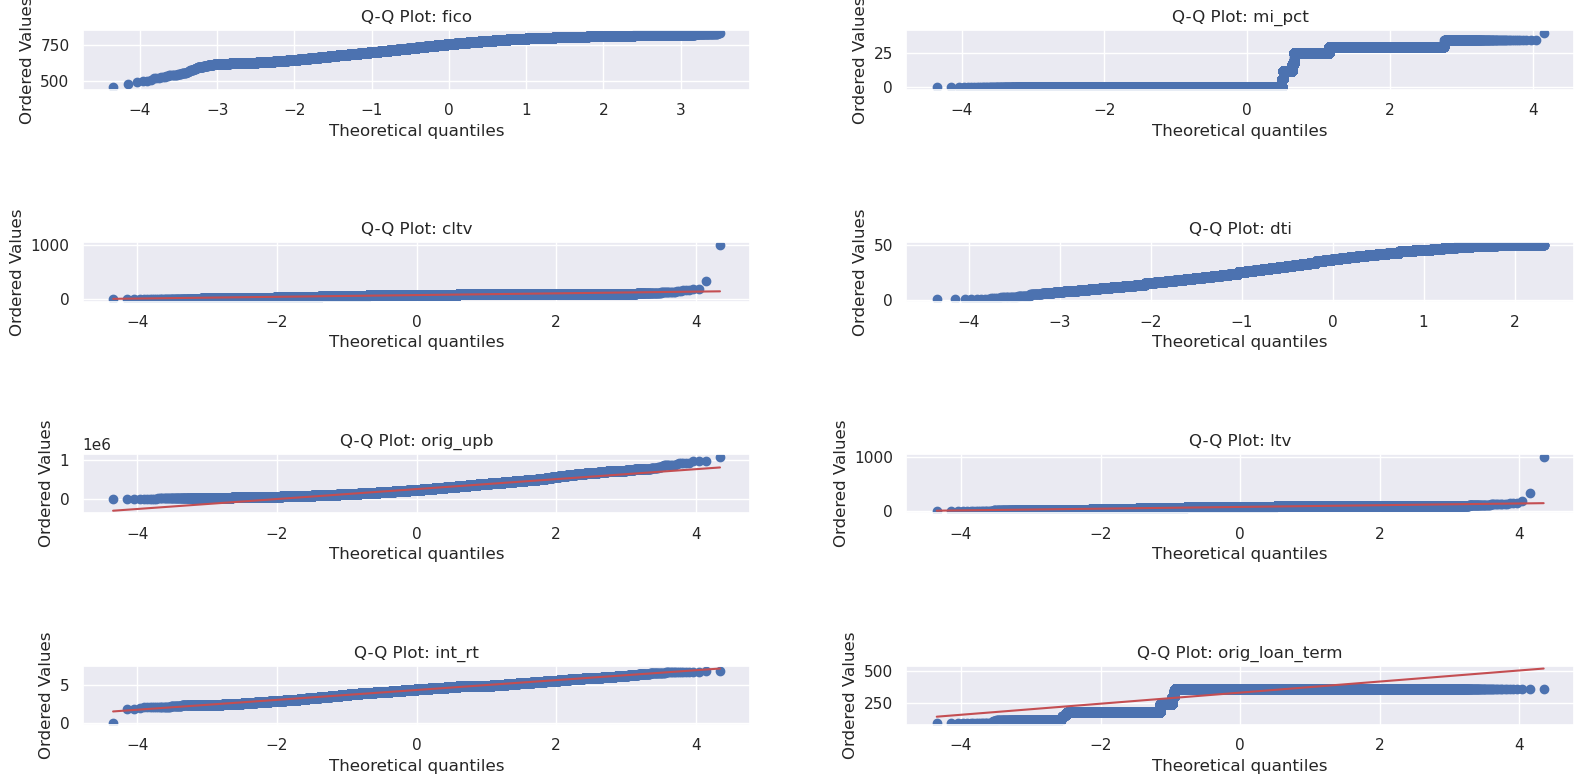

In [38]:
# Q-Q Plots for Normality Check
fig, axes = plt.subplots(4,2, figsize=(16,8))
axes = axes.flatten()
for i, feature in enumerate(numerical_cols):
    stats.probplot(train_data[feature], dist="norm", plot=axes[i])
    axes[i].set_title(f"Q-Q Plot: {feature}")

for j in range(len(numerical_cols), len(axes)):
    axes[j].axis("off")

plt.tight_layout(h_pad=5, w_pad=5)
plt.show()

*Figure 3: Q-Q plots indicating approximate normality for most continuous variables.*

Additionally, we present boxplots (Figure 4) to visualize potential outliers. While outliers are indeed present, we chose to keep them, believing they might represent meaningful cases or minority subgroups within the dataset. Removing them might erase valuable information, especially since they could represent cases of defaulted loans.

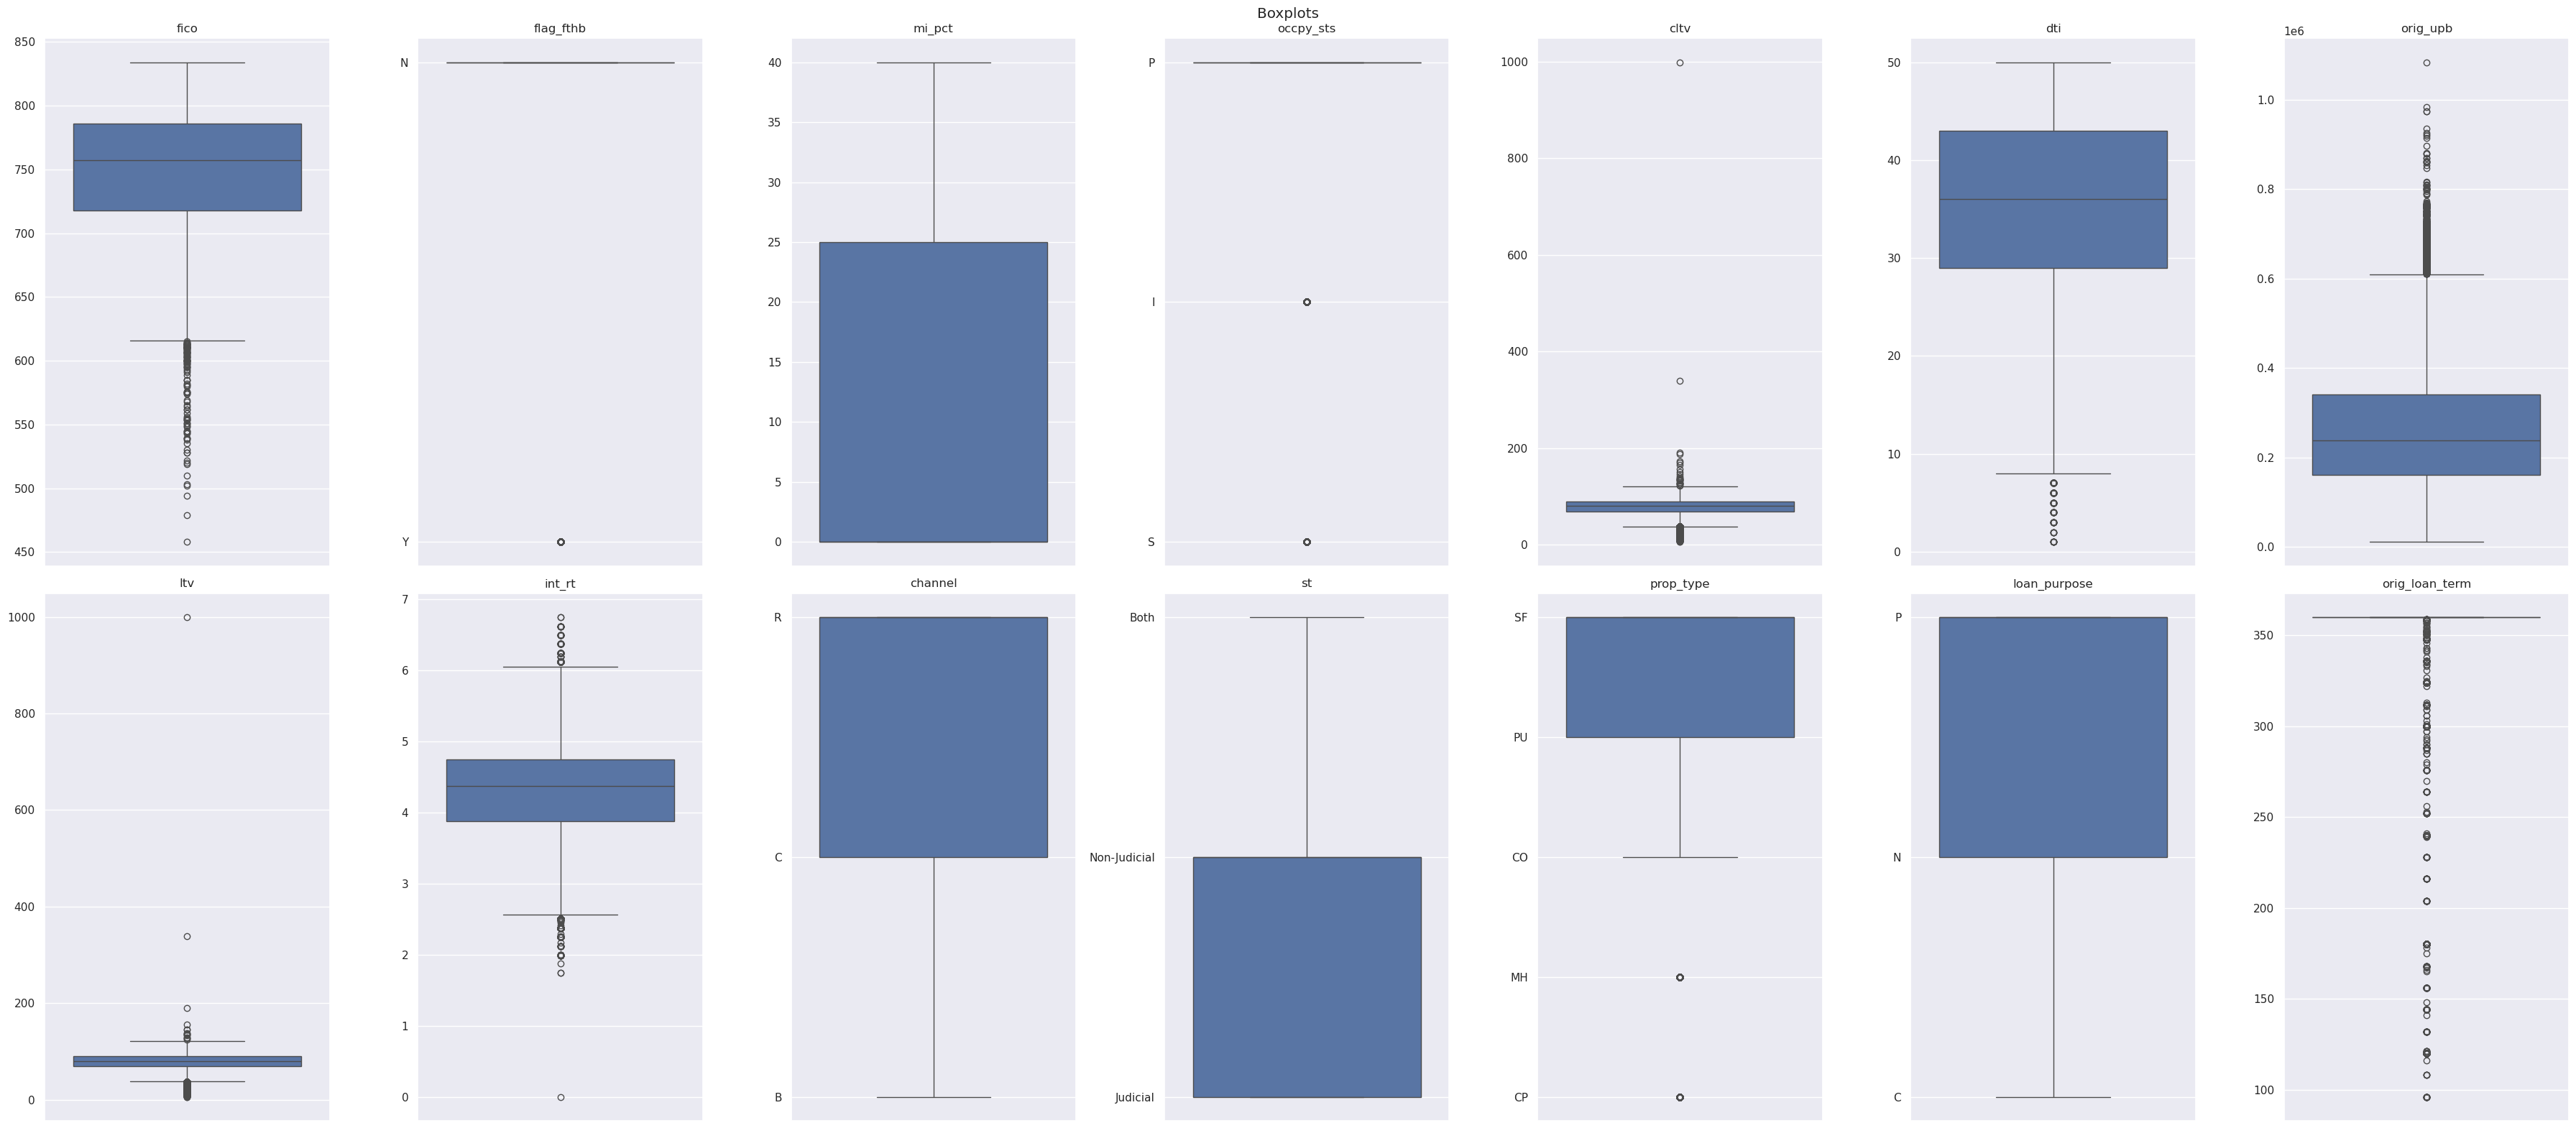

In [15]:
# Boxplots for Feature Distributions
fig, axes = plt.subplots(figsize=(36,16), ncols=X.shape[-1]//2, nrows=2, sharex=True)
axes = axes.flatten()
for i, ax in enumerate(axes):
    sns.boxplot(y=X_train.iloc[:, i], ax=ax)
    ax.set_title(X_train.columns[i])
    ax.set_ylabel("")
plt.suptitle("Boxplots")
plt.tight_layout()
plt.show()

*Figure 4: Boxplots revealing outliers in multiple variables.*

Finally, based on the above Exploratory Data Analysis, we have chosen to remove a final list of columns in hopes of improving generalization. As mentioned before, the correlation heatmaps showed a high correlation among CLTV, LTV, and MI_PCT. Thus, we decided to keep CLTV, as it reflects that CLTV (Combined Loan-to-Value) captures the total loan amount (including secondary financing) compared to the property’s appraised value, whereas LTV (Loan-to-Value) references only the original mortgage. On the other hand, MI_PCT was removed not only because of its high correlation with CLTV but also due to the skewness in its distribution, since most loans had zero loss coverage. Furthermore, orig_loan_term showed no significant differences when comparing mean values across defaulted versus paid loans, so it was also eliminated.

To conclude, these feature engineering steps were applied to both X_train and X_test, and the same transformations were applied to d_active_loans, a dataset containing only active loans. Once we have a working model, we plan to predict which and how many of these active loans are likely to default.

In [16]:
# Dropping columns after EDA
X_train = X_train.drop(["mi_pct","orig_loan_term","ltv"], axis=1)
X_test = X_test.drop(["mi_pct","orig_loan_term","ltv"], axis=1)

#Creating the active dataset that we would like to later applie our model, with the same feature engineering steps
d_active_loans = d[d['loan_status'] == 'active']
d_active_loans = d_active_loans.drop(["mi_pct", "orig_loan_term", "ltv"], axis=1)
d_active_loans = d_active_loans.drop(features_to_drop, axis=1)

Based on all the above data analysis, the foundation of our feature engineering can be broken down into two main parts: numerical and categorical preprocessing. First, we handle the numerical columns by imputing any empty cells with the median value of that column, using scikit-learn’s SimpleImputer. Notably, we enable the “add_indicator” parameter, which creates a separate feature indicating whether a given entry was imputed. This approach allows us to avoid discarding rows with missing values while ensuring that important information about missingness is retained. After imputation, the numerical features are standardized using StandardScaler, which subtracts the mean and divides by the standard deviation for each feature, bringing them to a common scale and helping prevent any single feature from dominating the model.

On the other hand, categorical variables are imputed with the most frequent category (again using SimpleImputer), then transformed via OneHotEncoder, which creates a binary (0/1) feature for each unique category. We employ the “handle_unknown='ignore'” setting to gracefully manage unforeseen categories in the test data.

Next, we apply a random undersampler to our entire feature set to address the significant imbalance in our data. This technique randomly selects samples from the majority class (fully paid loans) until the number of instances in both the default and fully paid categories is equal. Balancing the classes in this manner mitigates bias toward the dominant class and helps ensure that the model learns to distinguish between default and non-default loans more effectively.

By applying these pipelines to our classification task, we ensure that the model receives robust, well-structured input data. The imputation strategies help preserve as many data points as possible, while the scaling and encoding processes ensure that both numerical and categorical features are treated appropriately, mitigating issues such as differing scales or missing categories. Finally, the random sampler improves the imbalance of our data so the model is better able to predict the number of defaulted loans.

In [17]:
num_pre = Pipeline([
    ("num_impute", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])

cat_pre_full = Pipeline([
    ("num_impute", SimpleImputer(strategy="most_frequent")),
    ("cat_encode", OneHotEncoder(handle_unknown ="ignore"))
])

Under_Sampler = RandomUnderSampler(random_state=42)

In [18]:
# numeric vs. categorical columns in final pipeline

cat_col_positions = [1,2,7,8,9,10,11]
numerical_col_positions = [0,3,4,5,6]

# Model Fitting and Tuning

As we stated in the intoduction part of this report, the goal of our model is to predict whether a loan will end up being defaulted or be fully paid. This is based on the information provided by Freddie Mac and on our research. The data have been pre processed and different approaches have been considered to maximaze the predictive capabilities of our model. This is important since an accurate and interpretable model will aid in understanding the major contributers of loans that default, and will flag potiential high risk loans.

Thus, we initially explored a standard logistic regression (with and without regularization), Random Forest, Support Vectors and Neural Networks. After preliminary comparisons, we selected Random Forest due to its better performance in validation and its more interpretable nature. Below, we briefly describe the baseline model that is going to be used as a point of reference for our more advanced Random Forest model.

The baseline model is a $\ell_2$ regularization (ridge) logistic regression model with the basic feature engineering steps applied to all the model pipelines we tried. As mentioned before, there are three pre-processing steps that have been applied to give the model the best chance to perform well. We chose a logistic regression model with regularization to provide a point of reference, a model that lacks the more advance approaches but that can still deal with the high amount of features presented.

In [19]:
# Baseline logistic regression pipeline with regularization (L2)
reg_pipe_2 = ImPipeline([
    ("pre_processing", ColumnTransformer(
        [("num_pre", num_pre, numerical_col_positions),
        ("cat_pre_full", cat_pre_full, cat_col_positions),
        ])),
    ("sampler", Under_Sampler),
    ("model", LogisticRegression(random_state=42, penalty="l2", max_iter=1000))])

In [20]:
# Grid of possible C regularization values
C_list = np.linspace(0.01, 15, num=151)

# Set up GridSearchCV with multiple metrics (accuracy, f1, recall, precision)
log_rs = GridSearchCV(reg_pipe_2, 
                      param_grid={'model__C': C_list},
                      scoring = ["accuracy", "f1","recall","precision"],
                      cv = StratifiedKFold(n_splits=5, shuffle=True),
                      refit = "f1",
                      return_train_score = True)

# Train baseline model using grid search
baseline_model = log_rs.fit(X_train, y_train)
best_log_rs = baseline_model.best_estimator_

We systematically tuned the regularization strength by creating a grid of 𝐶 values (ranging from 0.01 to 15) and performed a StratifiedKFold cross-validation with five splits, ensuring each fold maintained the same default-to-non-default ratio as the overall dataset. We evaluated several metrics, including accuracy, F1, recall, and precision, and chose accuracy as our primary criterion for refitting. The best set of hyperparameters was selected based on cross-validation results, yielding a baseline metric against which we could compare more advanced models.

In [21]:
# Classification report for baseline model (train vs. test)
Train_report = classification_report(
    y_train, 
    best_log_rs.predict(X_train), 
    target_names=['Default', 'Non Default']
)
print("Table 5: Train Data Classification Report\n")
print(Train_report)

Test_report = classification_report(
    y_test, 
    best_log_rs.predict(X_test), 
    target_names=['Default', 'Non Default']
)
print("Table 6: Test Data Classification Report\n")
print(Test_report)

Table 5: Train Data Classification Report

              precision    recall  f1-score   support

     Default       0.01      0.70      0.03       597
 Non Default       1.00      0.69      0.81    100767

    accuracy                           0.69    101364
   macro avg       0.51      0.69      0.42    101364
weighted avg       0.99      0.69      0.81    101364

Table 6: Test Data Classification Report

              precision    recall  f1-score   support

     Default       0.01      0.63      0.02       149
 Non Default       1.00      0.69      0.82     25192

    accuracy                           0.69     25341
   macro avg       0.50      0.66      0.42     25341
weighted avg       0.99      0.69      0.81     25341



The above metrics show the baseline model’s real-world performance, with the similarity between training and test performance suggesting that the model is generalizing reasonably well and is not heavily overfitting. The model’s overall accuracy is 69%, accompanied by an F1-score for default loans of 0.03, a precision of 0.01, and a recall of 0.70. The confusion matrix below shows 95 true positives, 54 false negatives, and 7808 false positives, highlighting areas for improvement in detecting default loans.

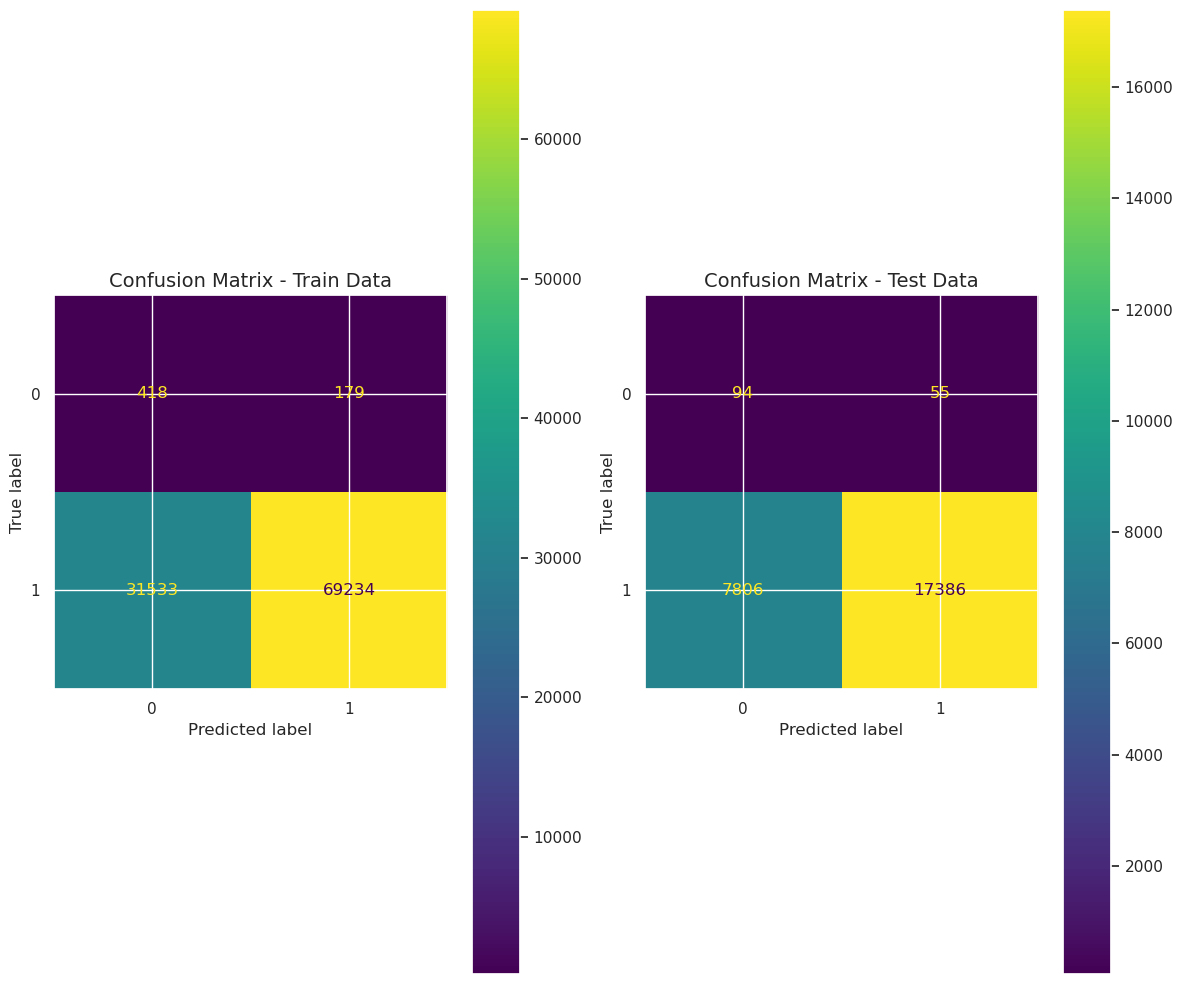

In [22]:
# Confusion matrices for baseline model (train & test)
fig, ax = plt.subplots(1, 2, figsize=(12, 10))

# Plot the confusion matrix for training data
ConfusionMatrixDisplay.from_estimator(best_log_rs, X_train, y_train, ax=ax[0])
ax[0].set_title("Confusion Matrix - Train Data", fontsize=14)
# Plot the confusion matrix for test data
ConfusionMatrixDisplay.from_estimator(best_log_rs, X_test, y_test, ax=ax[1])
ax[1].set_title("Confusion Matrix - Test Data", fontsize=14)

plt.tight_layout()
plt.show()

*Figure 5: Confusion Metrix of the Baseline Model*

Moving to the final model choice, it was mainly inspired by several reasons, first, after running cross-validation, Random Forest consistently outperformed the other models (Logistic Regression and Support Vector Machines) in identifying defaulted loans. It also manages noisy data and imbalanced classes effectively, reducing the risk of overfitting in a dataset with high imbalance. A key requirement was interpretability, which Random Forest addresses via feature importance measures, an aspect where it offers more transparency than many other algorithms. While Support Vector Machines also performed well, their decision boundary can be harder to interpret, especially without kernel-specific feature insights. Neural networks were excluded from consideration due to their “black box” nature; although powerful, they tend to lack the transparency we need for critical lending decisions.

In [23]:
# Advanced model pipeline: Random Forest with same preprocessing & under-sampling
Random_Forest = ImPipeline([
    ("pre_processing", ColumnTransformer(
        [("num_pre", num_pre, numerical_col_positions),
            ("cat_pre_full", cat_pre_full, cat_col_positions)]
    )),
    ("sampler", Under_Sampler),
    ("model", RandomForestClassifier(random_state=42, n_jobs=-1)
    )
])

The above code depicts the model pipeline used to construct our final Random Forest model. As mentioned in the feature engineering and baseline model sections, all models have had three main preprocessing steps that use the ColumnTransformer from the scikit-learn library. This transformer applies the subsequent steps to the relevant columns in the data, whether training or test, ensuring that there is no leakage between them. It applies numerical imputation to any missing continuous values using the median of each column, as we believed this would be the best approach without skewing columns that had a substantial number of missing values. The alternative, dropping rows with missing data, would have resulted in losing valuable information. Next, for categorical features, we used one-hot encoding, which created multiple columns as previously mentioned, and the final sampler step were random under sampling is applyied to the data so we can deal with imbalance. These features are then supplied into our Random Forest model to predict if a loan will default ot not.

To optimize our Random Forest model, we conducted a grid search over several key parameters, using a StratifiedKFold 5-fold cross-validation to maintain the original class distribution in each fold. Specifically, we tuned:

- n_estimators (the number of trees in the forest),

- max_features (the subset of features considered for splitting at each node),

- max_depth (the maximum depth allowed for each tree).

By systematically evaluating every combination of these parameter values, our primary objective was to maximize the F1 score, striking a balance between precision and recall. We monitored additional metrics (accuracy, recall, and precision) but used F1 as the “refit” metric to identify the best compromise between identifying default loans and limiting false alarms. This approach also helps maintain model interpretability, which is essential for understanding how different features contribute to the prediction of default risk.

In [43]:
# Grid for Random Forest hyperparameters
param_grid = {
    "model__n_estimators": [800, 1000, 1200],
    "model__max_features": ["sqrt"],
    "model__max_depth": [2, 5, 10]
}
# GridSearchCV setup for Random Forest with multiple metrics
Best_Random = GridSearchCV(
    estimator=Random_Forest,
    param_grid=param_grid,
    scoring = ["accuracy", "f1","recall","precision"],
    refit= "f1",
    cv = StratifiedKFold(n_splits=5, shuffle=True),
    n_jobs=-1,
)

# Fit the Random Forest via grid search
Advance_model = Best_Random.fit(X_train, y_train)
best_model_random = Advance_model.best_estimator_

print(f"Best combination of parameters that achived the highest f1 score: {Best_Random.best_params_}")

Best combination of parameters that achived the highest f1 score: {'model__max_depth': 2, 'model__max_features': 'sqrt', 'model__n_estimators': 800}


Subsequently, we created a grid of possible values for n_estimators, max_features and max_depth, then passed this grid to GridSearchCV, specifying each parameter with the prefix model__ to indicate that our Random Forest classifier is the “model” step in the pipeline. GridSearchCV systematically iterated over each combination of these parameters, training a new Random Forest model each time. Ultimately, it identified the parameter set that achieved the highest cross-validated F1 score, which we then selected as our optimal configuration.

The StratifiedKFold(n_splits=5, shuffle=True) cross-validation strategy was used to preserve class distribution in each fold. In each iteration, the data is split into training and validation subsets, and the model is fitted on four folds and evaluated on the remaining fold. This is repeated five times each with a different fold serving as the validation set. By averaging performance across these five folds, we obtain a robust estimate of the model’s generalizability. The dictionary in param_grid instructs scikit-learn to explore each parameter combination and choose the best one based on the cross-validated F1 metric.

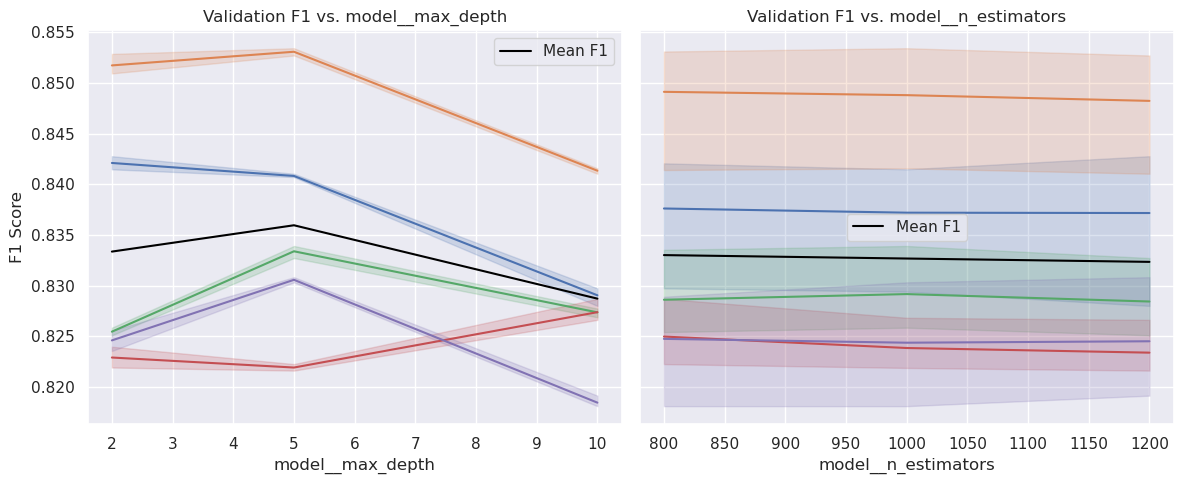

In [25]:
# Convert the grid search results to a DataFrame to examine
cv_results = pd.DataFrame(Best_Random.cv_results_)

# Focus on folds' F1 scores
cv_md = cv_results.filter(regex=r'(split[0-4]_test_f1|mean_test_f1)').copy()
cv_md = cv_md.assign(max_depth=cv_results['param_model__max_depth'])
d_md = cv_md.melt(
    id_vars=('max_depth', 'mean_test_f1'),
    var_name='fold',
    value_name='F1'
)


cv_ne = cv_results.filter(regex=r'(split[0-4]_test_f1|mean_test_f1)').copy()
cv_ne = cv_ne.assign(n_estimators=cv_results['param_model__n_estimators'])

d_ne = cv_ne.melt(
    id_vars=('n_estimators', 'mean_test_f1'),
    var_name='fold',
    value_name='F1'
)

# Plot F1 vs. max_depth and n_estimators
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.lineplot(x='max_depth', y='F1', data=d_md, color='black', errorbar=None, ax=axes[0], label='Mean F1')
sns.lineplot(x='max_depth', y='F1', hue='fold', data=d_md, ax=axes[0], legend=False)
axes[0].set_title("Validation F1 vs. model__max_depth")
axes[0].set_xlabel("model__max_depth")
axes[0].set_ylabel("F1 Score")


sns.lineplot(x='n_estimators', y='F1', data=d_ne, color='black', errorbar=None, ax=axes[1], label='Mean F1')
sns.lineplot(x='n_estimators', y='F1', hue='fold', data=d_ne, ax=axes[1], legend=False)
axes[1].set_title("Validation F1 vs. model__n_estimators")
axes[1].set_xlabel("model__n_estimators")
axes[1].set_ylabel("F1 Score")

plt.tight_layout()
plt.show()

*Figure 6: F1 Solution Path for max_depth and n_estimator parameters*

Visualising from what we were explaining before, Figure 6 shows how F1 changes as estimators and max_depth increases. The black curve shows the overall (mean) F1 across all folds at each step while the colored lines represent the individual folds, ilustrating variance between splits, with different folds responding slightly differently, but the overall mean (black line) typically has a clear minimum region. The best n_estimators and max_depth found by GridSearchCV is where the average f1 is the highest. Thus, we conclude that GridSearchCV + 5-fold cross-validation not only provides an optimal hyperparameter for our Random Forest model but also offers insight into how the model’s predictive performance changes across different amounts of estimators.

In [26]:
# Classification reports (train vs. test) for best Random Forest model
Train_report = classification_report(
    y_train, 
    best_model_random.predict(X_train), 
    target_names=['Default', 'Non Default']
)
print("Table 7: Train Data Classification Report\n")
print(Train_report)

Test_report = classification_report(
    y_test, 
    best_model_random.predict(X_test), 
    target_names=['Default', 'Non Default']
)
print("Table 8: Test Data Classification Report\n")
print(Test_report)

Table 7: Train Data Classification Report

              precision    recall  f1-score   support

     Default       0.02      0.69      0.03       597
 Non Default       1.00      0.73      0.85    100767

    accuracy                           0.73    101364
   macro avg       0.51      0.71      0.44    101364
weighted avg       0.99      0.73      0.84    101364

Table 8: Test Data Classification Report

              precision    recall  f1-score   support

     Default       0.01      0.64      0.03       149
 Non Default       1.00      0.73      0.85     25192

    accuracy                           0.73     25341
   macro avg       0.51      0.69      0.44     25341
weighted avg       0.99      0.73      0.84     25341



Above and below, the results reveal that our improved model maintains the same number of true positives (95) as the baseline but reduces false positives by approximately 1,200 cases, thereby increasing overall accuracy. As shown in Table 7 and Table 8, the accuracy reaches 73% on the test set, reflecting a notable improvement in distinguishing genuine default loans from non-defaults. Despite the low precision for the default class, the relatively higher recall (0.64) indicates that the model captures more potential defaults than before an important consideration in lending decisions. Although these metrics have room for growth (particularly in raising precision), the significant reduction in false positives mitigates the potentially high cost of incorrectly classifying non-default loans, thus steering the model toward a more practical balance between risk management and classification accuracy.

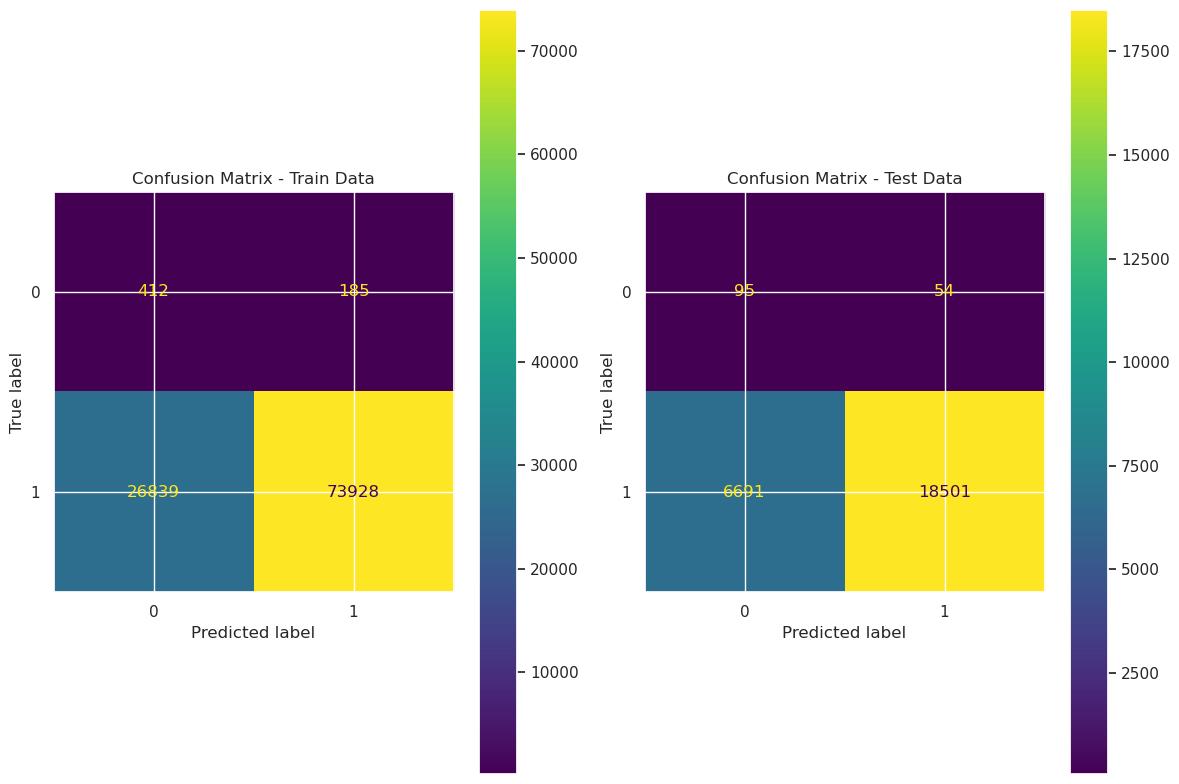

In [27]:
# Confusion matrices for the Random Forest model (train & test)
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# Plot the confusion matrix for training data
ConfusionMatrixDisplay.from_estimator(best_model_random, X_train, y_train, ax=ax[0])
ax[0].set_title("Confusion Matrix - Train Data")
# Plot the confusion matrix for test data
ConfusionMatrixDisplay.from_estimator(best_model_random, X_test, y_test, ax=ax[1])
ax[1].set_title("Confusion Matrix - Test Data")

plt.tight_layout()
plt.show()

*Figure 7: Confusion Metrix of the Advance Model Model*

Below, this snippet compares our two models the baseline and one advanced Random Forest by plotting both their ROC (Receiver Operating Characteristic) curves. It demonstrates how each model’s probabilities are used to calculate key the ROC performance metric, which are then visualized side by side:

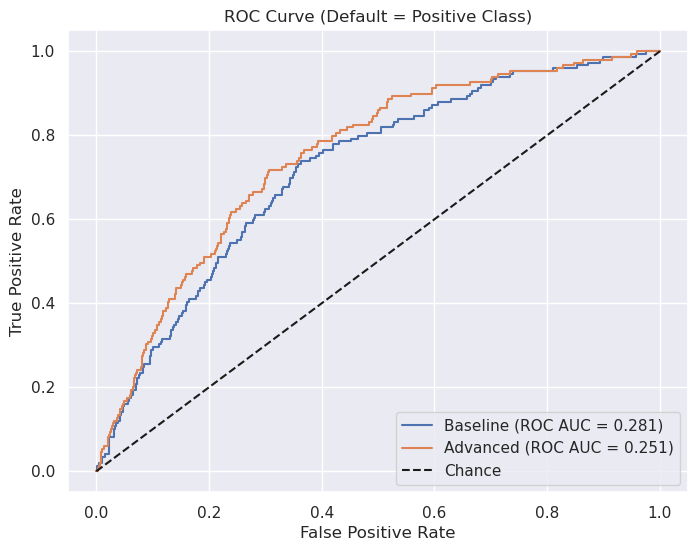

In [36]:
# Probability predictions for class 0 (Default)
y_pred_proba_baseline = best_log_rs.predict_proba(X_test)[:, 0]
y_pred_proba_advanced = best_model_random.predict_proba(X_test)[:, 0]

# Compute ROC metrics for the baseline model
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline, pos_label=0)
roc_auc_baseline = roc_auc_score(y_test, y_pred_proba_baseline)

# Compute ROC metrics for the advanced model
fpr_advanced, tpr_advanced, _ = roc_curve(y_test, y_pred_proba_advanced, pos_label=0)
roc_auc_advanced = roc_auc_score(y_test, y_pred_proba_advanced)

# Plot ROC curves for both models
plt.figure(figsize=(8, 6))
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline (ROC AUC = {roc_auc_baseline:.3f})')
plt.plot(fpr_advanced, tpr_advanced, label=f'Advanced (ROC AUC = {roc_auc_advanced:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Default = Positive Class)')
plt.legend(loc='lower right')
plt.show()

*Figure 8: ROC Curve Comparison Between The Baseline and Advance Model*

In Figure 8, the ROC values for both models fall below 0.5 largely because the labeling has been inverted to treat “default” (class 0) as the positive class, whereas the models were originally set up to predict “paid” as positive. Despite the inversion, both models exhibit similar ROC performance—with the Baseline model showing a slightly higher ROC AUC under this framing.

Next, to examine which features had the highest impact, we extract the feature importance from the "feature_importances_" parameter of our Random Forest model:

Table 9: Top 10 Key Factors Affecting Loan Default Risk
num_pre__fico                     0.308838
num_pre__orig_upb                 0.121180
num_pre__int_rt                   0.119769
num_pre__dti                      0.086008
num_pre__cltv                     0.080135
cat_pre_full__property_val_3.0    0.042174
cat_pre_full__st_Judicial         0.027788
cat_pre_full__property_val_1.0    0.026583
cat_pre_full__st_Non-Judicial     0.019455
cat_pre_full__prop_type_PU        0.018806
dtype: float64


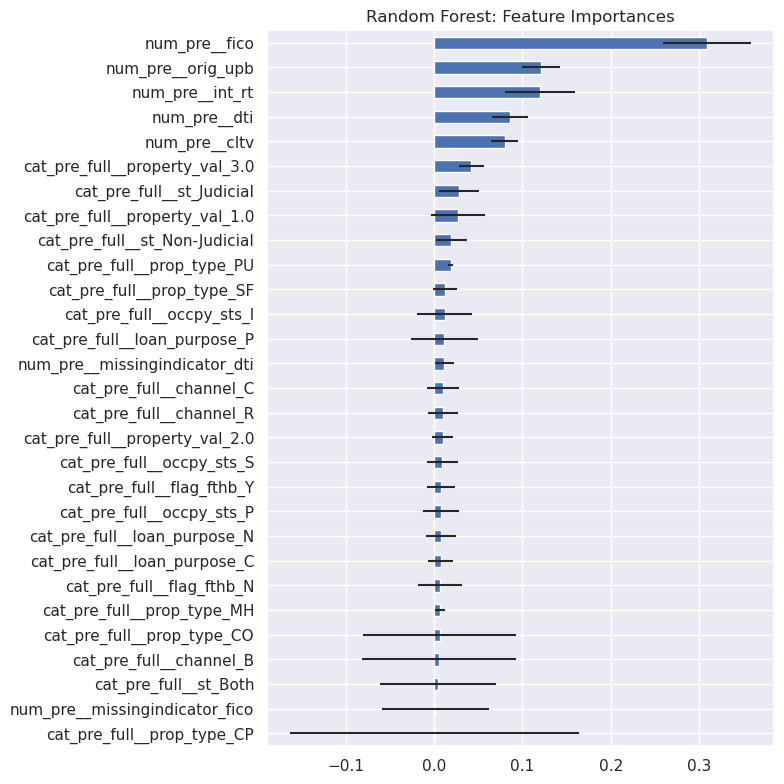

In [29]:
# Extract and plot feature importances from the best Random Forest model
model = best_model_random.named_steps["model"]
feature_names = best_model_random.named_steps["pre_processing"].get_feature_names_out()

# Standard deviation of feature importances across all trees
std = np.std([tree.feature_importances_ for tree in best_model_random["model"].estimators_], axis=0)

# Sort feature importances in ascending order
importances_rf = pd.Series(best_model_random["model"].feature_importances_, index=feature_names).sort_values(ascending=True)

# Plot the feature importances
plt.figure(figsize=(8, 8))
ax = importances_rf.plot.barh(xerr=std)
ax.set_title("Random Forest: Feature Importances")
ax.figure.tight_layout()

print("Table 9: Top 10 Key Factors Affecting Loan Default Risk")
print(importances_rf.sort_values(ascending=False).head(10))

*Figure 9: Random Forest Feature Importances*

The figure above (Figure 9) illustrates the feature importances from our final Random Forest model. Each horizontal bar represents the mean contribution of a given feature across all decision trees in the ensemble, while the error bars (xerr) indicate the standard deviation of these contributions. Features toward the right (larger bar) have a greater impact on the model’s classification of default versus non-default loans, whereas those closer to the left play a relatively smaller role. 

# Active Loans Risk Assessment

Below is a concise recap of our process for predicting risk on the active loans dataset. First, we used our trained Random Forest model to estimate each loan’s probability of default. Next, we applied predefined thresholds to classify those probabilities into three categories:

- Low Risk: Probability of default < 0.05

- Medium Risk: Probability of default < 0.30

- High Risk: Probability of default ≥ 0.30

Finally, we aggregated the results to see how many loans fell into each category, helping us pinpoint those that pose the greatest potential risk. This allows Freddie Mac to prioritize monitoring and intervention for the highest-risk loans.

Distribution of Default Risk Among Active Loans:
               Count  Percentage
risk_category                   
High Risk      66878   91.244969
Medium Risk     6417    8.755031


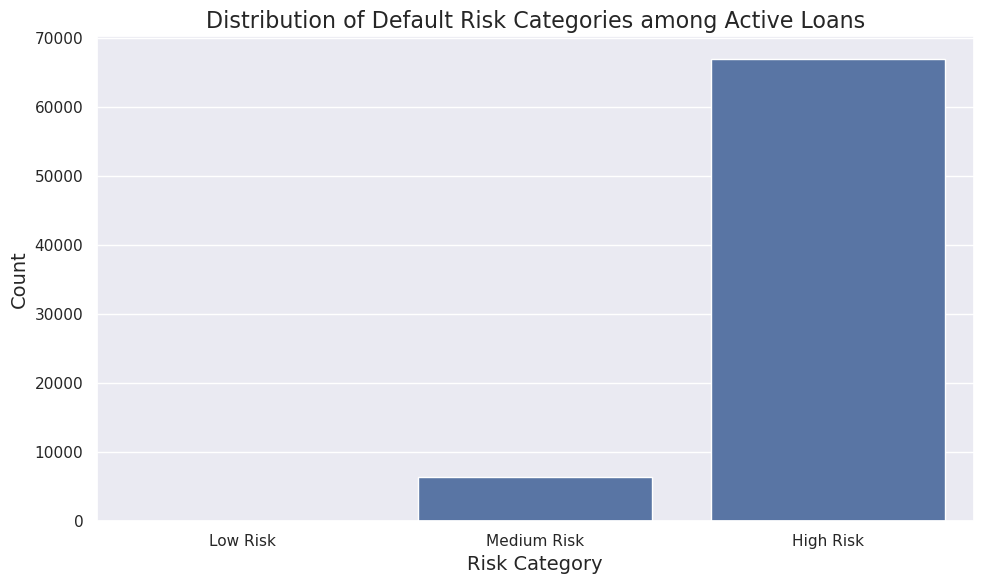

In [30]:
active_loans = d_active_loans.copy()
active_loans['default_probability'] = best_model_random.predict_proba(active_loans)[:, 0]

# Define risk categories based on the probability thresholds
def assign_risk_category(prob):
    if prob < 0.05:
        return 'Low Risk'
    elif prob < 0.30:
        return 'Medium Risk'
    else:
        return 'High Risk'

active_loans['risk_category'] = active_loans['default_probability'].apply(assign_risk_category)

#Print out the distribution of risk categories
risk_counts = active_loans['risk_category'].value_counts()
risk_percents = active_loans['risk_category'].value_counts(normalize=True) * 100
risk_df = pd.DataFrame({'Count': risk_counts, 'Percentage': risk_percents})

print("Distribution of Default Risk Among Active Loans:")
print(risk_df)

#Plot the distribution of default risk categories among active loans
plt.figure(figsize=(10, 6))
sns.countplot(
    data=active_loans, 
    x='risk_category', 
    order=['Low Risk', 'Medium Risk', 'High Risk']
)
plt.title('Distribution of Default Risk Categories among Active Loans', fontsize=16)
plt.xlabel('Risk Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()
plt.show()

# Discussion & Conclusions

Our final Random Forest model achieved a notable improvement in predicting whether a loan would default or be fully paid off when compared to the baseline Logistic Regression and Support Vector Machine approaches. Specifically, it demonstrated an accuracy of approximately 73% on the test set, with a significant reduction in false positive default loans. In practical terms, it identified more true defaults than the baseline while simultaneously reducing false positive identified loans by around 1,200. This balance between capturing genuine defaults and avoiding undue misclassifications is especially important in the lending industry, as it helps mitigate financial loss and supports more informed risk management.

A key advantage of this Random Forest lies in its ability to offer interpretable insights through feature importances. As shown in Figure 9 and Table 9, loan characteristics such as fico, orig_upb, int_rt, dti, and cltv consistently emerged as the strongest predictors. Higher credit scores (fico) generally signaled lower default risk, while loans with larger principal balances (orig_upb) or higher interest rates (int_rt) posed a greater threat of default, aligning with established industry understanding. In addition, we found that debt to income ratio (dti) and combined loan to value (cltv) were pivotal in discriminating higher risk borrowers, underscoring the roles of borrower capacity and home equity in loan performance. An honorable mention goes to “cat_pre_full__st_Judicial,” which identifies states with judicial foreclosure laws requiring a court hearing and a judge’s order to approve the foreclosure process. This highlights the potential for further improving the model’s predictive capabilities by incorporating additional external data related to regional legal frameworks.

From a real-world perspective, lenders can use these findings to refine underwriting processes, prioritize at-risk loans for early intervention, and communicate key risk factors to regulators and stakeholders in a transparent manner. By applying thresholds to the model’s probabilities of default, we classified active loans into Low, Medium, and High risk categories, allowing Freddie Mac to allocate resources more efficiently. Loans flagged as High Risk warrant closer monitoring or enhanced servicing strategies aimed at preventing default, potentially reducing losses for both the lender and the borrower.

Despite these positive outcomes, caution is advised when interpreting the results. First, the model though robust still exhibits relatively low precision for defaulted loans, meaning it incorrectly flags some non-default loans as likely defaults. This imprecision can lead to unnecessary interventions or elevated costs. Second, while the Random Forest provides more transparency than some black box methods (e.g., neural networks), it remains an ensemble of decision trees whose interactions are not as straightforward to parse as simpler models. Furthermore, the dataset may not perfectly represent all borrower demographics or economic conditions, introducing uncertainty about how well the findings would generalize to different markets or time frames. Future research could address these limitations by incorporating more granular data (e.g., macroeconomic indicators, borrower behavior over time) or by tailoring the information to represent specific geographical locations better. I beleve a substantial improvement could be achieved by incorporating the geographic context of the loan, such as whether it is located in a high cost urban area or a more affordable region. Although some location data are available, cross referencing it with loan amounts and borrower salaries may provide deeper insights. Large cities, for instance, typically have higher living costs and inflation turnover, which can significantly influence a borrower’s default risk factors not fully captured in the current model.

Overall, this model delivers a practical and interpretable solution for Freddie Mac, offering clear benefits over the baseline approach in managing default risk. By highlighting the most influential features, it enables targeted strategies to reduce loan losses and meet regulatory expectations for transparency. In the future, extending the model to include broader variables and validating it across diverse cohorts would bolster its reliability. Nonetheless, as it stands, our Random Forest framework provides a strong foundation for risk assessment and a scalable avenue for continued improvement in mortgage default prediction.

# Generative AI statement

Generative AI was used for generating explanations for error messages and debugging, providing hints or suggestions to improve code, enhancing visualizations and the quality of the report.

# References

In [44]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf ICA_2.ipynb

[NbConvertApp] Converting notebook ICA_2.ipynb to pdf
[NbConvertApp] Support files will be in ICA_2_files/
[NbConvertApp] Making directory ./ICA_2_files
[NbConvertApp] Writing 126375 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 827455 bytes to ICA_2.pdf


# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

Constantinos Mavrommatis and Matt Carre

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [1]:
# Install imbalanced-learn for undersampling
#!pip install imblearn

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# sklearn modules
import sklearn
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import average_precision_score

In [2]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")

/tmp/ipykernel_16377/166865228.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv("freddiemac.csv")


# Introduction

In this report, we propose a model to predict whether a loan will default or be paid off using Freddie Mac’s Single Family Loan Level Dataset from 2017 to 2020. Our approach centers on a Random Forest classifier, an ensemble method known for its effectiveness in handling complex interactions among features, class imbalance, and data noise all crucial aspects of credit risk analysis. The dataset includes information such as borrowers FICO scores, loan-to-value ratios, interest rates, and various categorical indicators. We also incorporate details like whether the loan resides in a judicial or non-judicial foreclosure state to account for regional legal differences.

In our final configuration, the Random Forest model demonstrated notable improvements in both accuracy and recall compared to our baseline Logistic Regression. The model achieved a 73% accuracy score and, more importantly, correctly identified 95 out of 149 defaulted loans in the test set, a strong result given the high class imbalance often found in these types of datasets. This enhanced predictive performance stems from the Random Forest’s ability to evaluate a wide array of interaction effects, particularly valuable in capturing the multifaceted nature of loan default risk while simultaneously reducing overfitting through ensembling. By systematically evaluating key hyperparameters and preserving interpretability via feature importance measures, our approach ensures that the reasons behind a given loan’s risk level are transparent to stakeholders.

Additionally, we applied the model to the currently active loans to gauge which might be at high risk of default. About 91% were classified as high risk and 9% as moderate, likely due to the model’s current threshold or predictive capabilities. Adjusting this threshold based on Freddie Mac’s domain expertise could yield a more balanced risk assessment or help prioritize loans for closer monitoring.

For a financial institution like Freddie Mac, our findings offer a foundation for early risk detection and targeted intervention. By uncovering the principal drivers of default, such as high debt-to-income ratios or unfavorable loan terms, decision-makers can implement strategies—like underwriting policies or borrower support initiatives to mitigate potential losses. Subsequent sections detail the data preprocessing steps, the rationale for Random Forest over other algorithms, the final model’s performance metrics, and real-world applications of these insights for lending practices and regulatory compliance.

# Exploratory Data Analysis and Feature Engineering

In this section, we will be discussing the thought process that guided our selection of which features to include in the final model, that ultimately predicts if an individual will default on there loans. We also explore the data for important findings or ways to improve model selection.

First, due to the structure of the dataset where missing information for different columns is presented in a non-standardized format using various numerical error codes, we had to map these error codes so that we could convert them into null values for the later steps of our feature engineering, allowing us to clearly evaluate the data without any skewness.

In [3]:
# Create a dictionary mapping for error codes
error_map = {
    "fico": 9999,         
    "flag_fthb": 9,
    "cnt_units": 99,
    "occpy_sts": 9,
    "prop_type": 99,
    "mi_pct": [999],        
    "dti": 999,            
    "cnt_borr": 99,
    "mi_cancel_ind": "7",
    "property_val": 9,
    "channel": 9
}

# Replace the error values in each relevant column with NaN
for col, error_value in error_map.items():
    if col in d.columns:
        d[col] = d[col].replace(error_value, np.nan)

Subsequently, Table 1 summarizes the data types and the null counts in each column. Columns with int64 and float64 are continuous features, whereas object types are categorical features, this distinction is crucial for the preprocessing of the model pipeline, because different features require different imputation or encoding methods in our pipeline. Moreover, the table reveals that certain columns contain missing data and need an imputation strategy to fill the missing values. That is because if we dropped rows with missing data, we would be losing data equivalent to the null count percentage, which is undesirable with further complications of scikit-learn not being able to handle missing values well.

In [4]:
# Convert columns to appropriate dtypes before summarizing
d['property_val'] = d['property_val'].astype('object')
d['cnt_units'] = d['cnt_units'].astype('object')

# Create a summary DataFrame of data types and missing values
summary = pd.DataFrame({
    'Data Type': d.dtypes,
    'Non-Null Count': d.count(),
    'Null Count': d.isna().sum(),
    'Null Count Percentage': round((d.isna().sum() / len(d)) * 100)
})
print("\nTable 1: A summary of the dataset, showing data types, non-null counts, and missing values.\n")
display(summary)


Table 1: A summary of the dataset, showing data types, non-null counts, and missing values.



,Data Type,Non-Null Count,Null Count,Null Count Percentage
fico,float64,199959,41,0.0
dt_first_pi,int64,200000,0,0.0
flag_fthb,object,200000,0,0.0
dt_matr,int64,200000,0,0.0
cd_msa,float64,181072,18928,9.0
mi_pct,float64,199999,1,0.0
cnt_units,object,200000,0,0.0
occpy_sts,object,200000,0,0.0
cltv,int64,200000,0,0.0
dti,float64,197588,2412,1.0


Furthermore, our dataset included multiple columns that were redundant, for example two "ID" (id_loan, id_loan_rr) and two "Date" (dt_first_pi, dt_matr) columns, as well as several pieces of information that did not seem to meaningfully improve our model’s ability to predict loan outcomes. Other variables such as servicer_name, seller_name, cnt_borr, and program_ind were also removed because their contributions were either redundant or already captured by stronger predictors in the dataset. Additionally, cd_msa and flag_sc where removed due to the high null count that they presented. 

In [5]:
# List of columns to drop as identified during initial exploration
features_to_drop = [
    "dt_first_pi",
    "dt_matr",
    "zipcode", 
    "id_loan",
    "servicer_name",
    "id_loan_rr",
    "program_ind",
    "io_ind",
    "prod_type",
    "ppmt_pnlty",
    "seller_name",
    "cnt_borr",
    "rr_ind",
    "cd_msa", #mention
    "loan_status",
    "mi_cancel_ind",
    "cnt_units",
    "flag_sc" #mention
]

On the other hand, an interesting piece of information was the state code, which captures geographical differences but did not initially improve performance. However, this does not imply that location is unimportant; rather, it may need to be combined with more granular data that is not present in our dataset to reveal a meaningful effect. Thus, through additional research, information about states’ judicial foreclosure status was integrated and mapped to the “st” column in the hope that this transformation would enhance the model’s accuracy. Finally, in order to focus solely on defaulted and fully paid loans, we removed any active loans (those with loan_status labeled as “active”). Excluding these active loans helps ensure our model is trained only on definitive outcomes, thus refining its predictive capabilities for default versus repayment.

In [6]:
# Dictionary mapping state -> foreclosure type
foreclosure_mapping = {
    'CA': 'Non-Judicial', 'TX': 'Non-Judicial', 'FL': 'Judicial', 'IL': 'Judicial',
    'MI': 'Judicial', 'OH': 'Judicial', 'AZ': 'Non-Judicial', 'WA': 'Non-Judicial',
    'CO': 'Non-Judicial', 'GA': 'Non-Judicial', 'NC': 'Non-Judicial', 'NY': 'Judicial',
    'PA': 'Judicial', 'VA': 'Non-Judicial', 'NJ': 'Judicial', 'IN': 'Judicial',
    'MA': 'Non-Judicial', 'MN': 'Both', 'MO': 'Both', 'TN': 'Non-Judicial',
    'UT': 'Non-Judicial', 'OR': 'Non-Judicial', 'MD': 'Both', 'WI': 'Judicial',
    'SC': 'Judicial', 'NV': 'Non-Judicial', 'KY': 'Judicial', 'AL': 'Non-Judicial',
    'LA': 'Judicial', 'CT': 'Judicial', 'OK': 'Non-Judicial', 'KS': 'Judicial',
    'IA': 'Judicial', 'ID': 'Non-Judicial', 'AR': 'Non-Judicial', 'NH': 'Non-Judicial',
    'NE': 'Non-Judicial', 'NM': 'Judicial', 'ME': 'Non-Judicial', 'DE': 'Judicial',
    'MS': 'Non-Judicial', 'MT': 'Non-Judicial', 'RI': 'Non-Judicial', 'HI': 'Non-Judicial',
    'WV': 'Judicial', 'ND': 'Judicial', 'DC': 'Judicial', 'SD': 'Non-Judicial',
    'VT': 'Judicial', 'AK': 'Non-Judicial', 'WY': 'Non-Judicial', 'GU': 'Judicial',
    'PR': 'Judicial', 'VI': 'Judicial'
}

# Map each row's state code to its foreclosure type
d['st'] = d['st'].map(foreclosure_mapping)

# Remove any active loans
d_no_active = d[d['loan_status'] != 'active']

# Extract features and target variable
y = d_no_active['loan_status'].copy()
X = d_no_active.drop(features_to_drop, axis=1)

# Encode 'default' vs. 'paid' with LabelEncoder
y = LabelEncoder().fit_transform(y)

Before building our model, the data was split into training and testing sets using train_test_split with a 80/20 ratio, seeded by a random state. Splitting ensures that the model learns based on training data only, avoiding any data leakage. Due to the high imbalance between defaulted and repaid loans, we employed stratification to maintain the representative distribution of the target variable.

In [7]:
# Split data into training and testing sets
rng = np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True, stratify=y, test_size = 0.2, random_state=rng)

In [8]:
# Combine X_train and y_train into a single DataFrame
train_data = X_train.copy()
train_data["loan_status"] = y_train  # Adding y_train as a column

In [9]:
# Quick checks for distribution of default vs. non-default
overall_pct = pd.Series(y).value_counts(normalize=True) * 100
train_pct = pd.Series(y_train).value_counts(normalize=True) * 100
test_pct = pd.Series(y_test).value_counts(normalize=True) * 100

# Summarize these distributions in a table
summary_table = pd.DataFrame({
    'Overall (%)': overall_pct,
    'Train (%)': train_pct,
    'Test (%)': test_pct
})

print("\nTable 2: Distribution of Non Defaults(1)/Defaults(0): Across Overall, Training, and Test Datasets.\n")

# Display the summary table.
display(summary_table)


Table 2: Distribution of Non Defaults(1)/Defaults(0): Across Overall, Training, and Test Datasets.



,Overall (%),Train (%),Test (%)
1,99.411231,99.411034,99.41202
0,0.588769,0.588966,0.58798


In preparation for exploring the data, we separate continuous and categorical features:

In [10]:
#Extraction of Numerical and Categorical Columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

The following histograms (Figure 1) display approximate counts and skew for each categorical feature, including proverty_val, which despite being numeric behaves more like a categorical predictor here. These plots also illustrate the presence of minority groups in the categorical data, which influences whether we combine them using max_categories in our one-hot encoding approach later. Most likely, we will not choose to have a limited number of categories to produce since due to the high inbalance in the data, the categories with the small number of counts might be a good performance indicator:

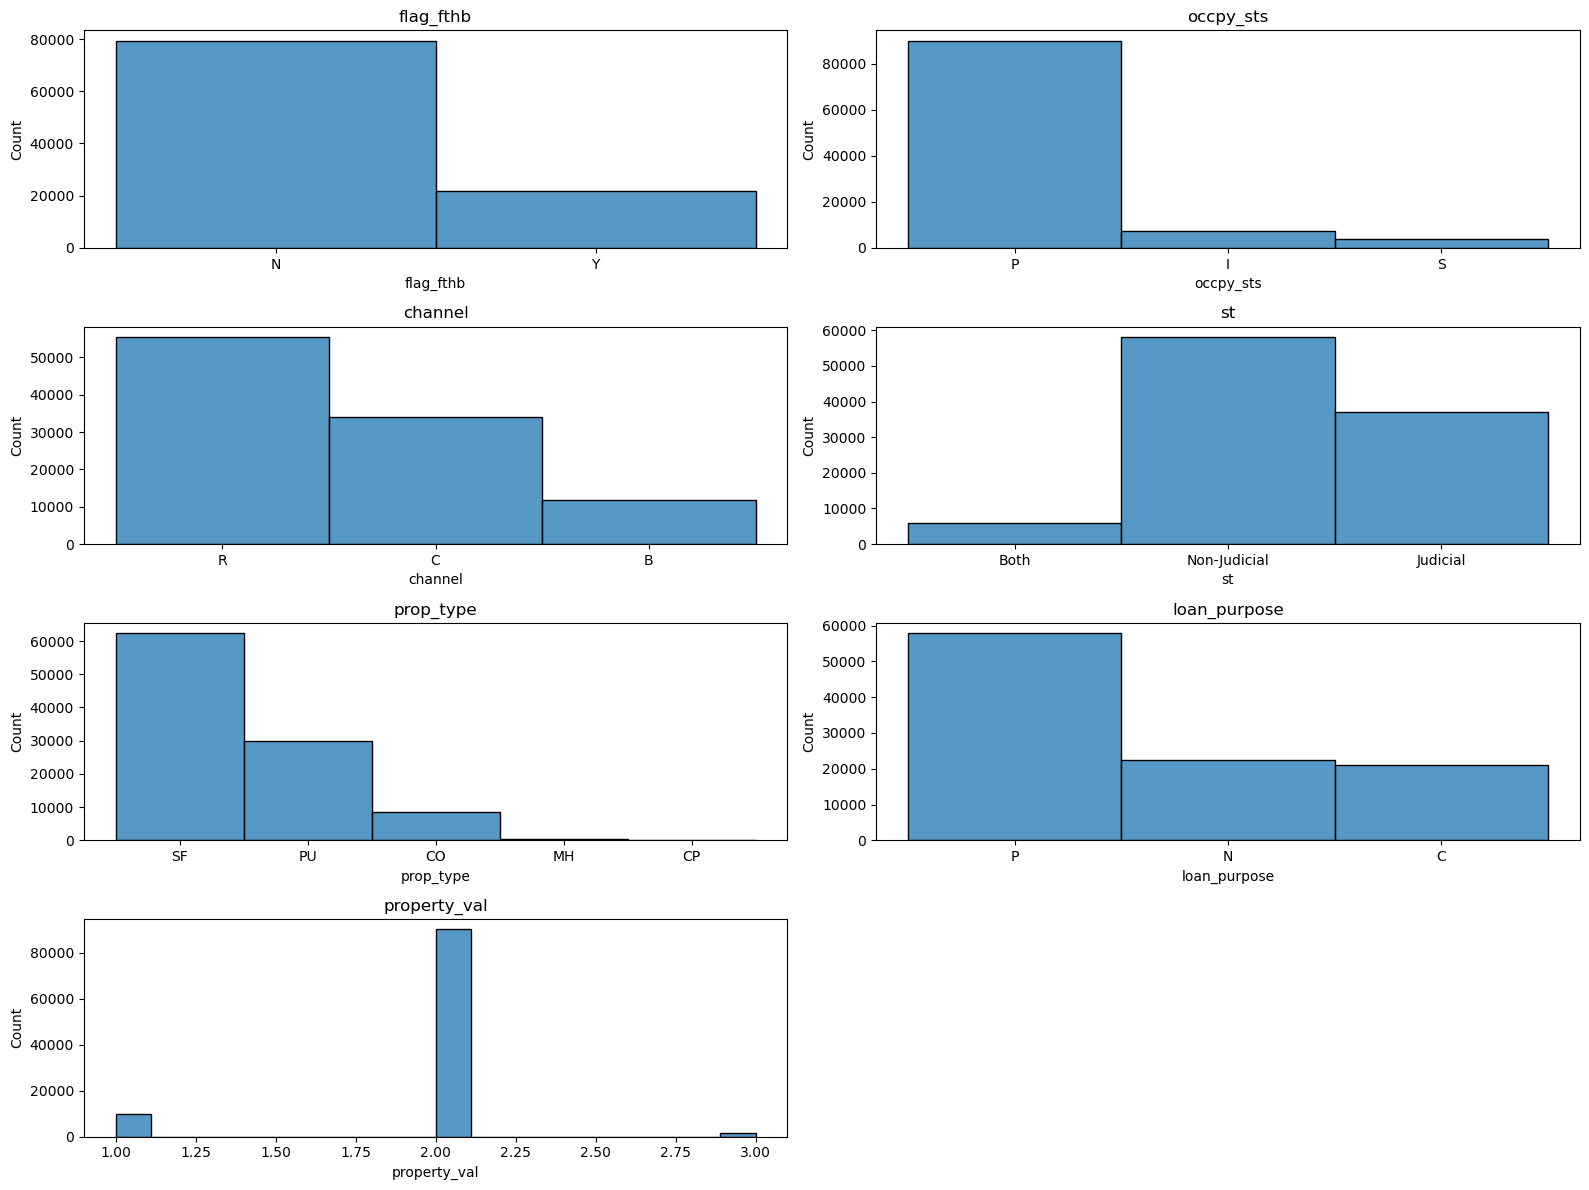

In [11]:
# Creation of subplots
fig, axes = plt.subplots(figsize=(16, 12), nrows=4, ncols=2)
axes = axes.flatten()

# Plot a countplot for each categorical feature
for i, feature in enumerate(categorical_cols):
    sns.histplot(x=X_train[feature], ax=axes[i])
    axes[i].set_title(feature)

# Turn off any extra subplots if there are fewer features than axes
for j in range(len(categorical_cols), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

*Figure 1: Count distributions for each categorical feature in X_train.*

To investigate feature relationships, we next examined how each predictor correlates with our target variable, which also helps identify features that could be removed or combined to improve generalization (Figure 2). We found no numeric features with a strong direct correlation to the loan status. However, our correlation analysis did reveal that certain features such as CLTV, LTV, and MI_PCT are highly correlated with one another. We confirm these relationships more rigorously using Pearson’s correlation test (Table 3), ensuring they are unlikely to be due to random chance. Consequently, we chose to remove some of these features to reduce redundancy and multicollinearity, thereby simplifying our model and minimizing the risk of overfitting. This approach ensures that each remaining predictor contributes unique, meaningful information.


Table 3: Correlation Analysis With P-Values

Highly correlated feature pairs (|r| >= 0.4) with P-Values:


,Feature 1,Feature 2,Correlation,P-Value
2,cltv,ltv,0.991250,0.0
1,mi_pct,ltv,0.664998,0.0
0,mi_pct,cltv,0.657505,0.0


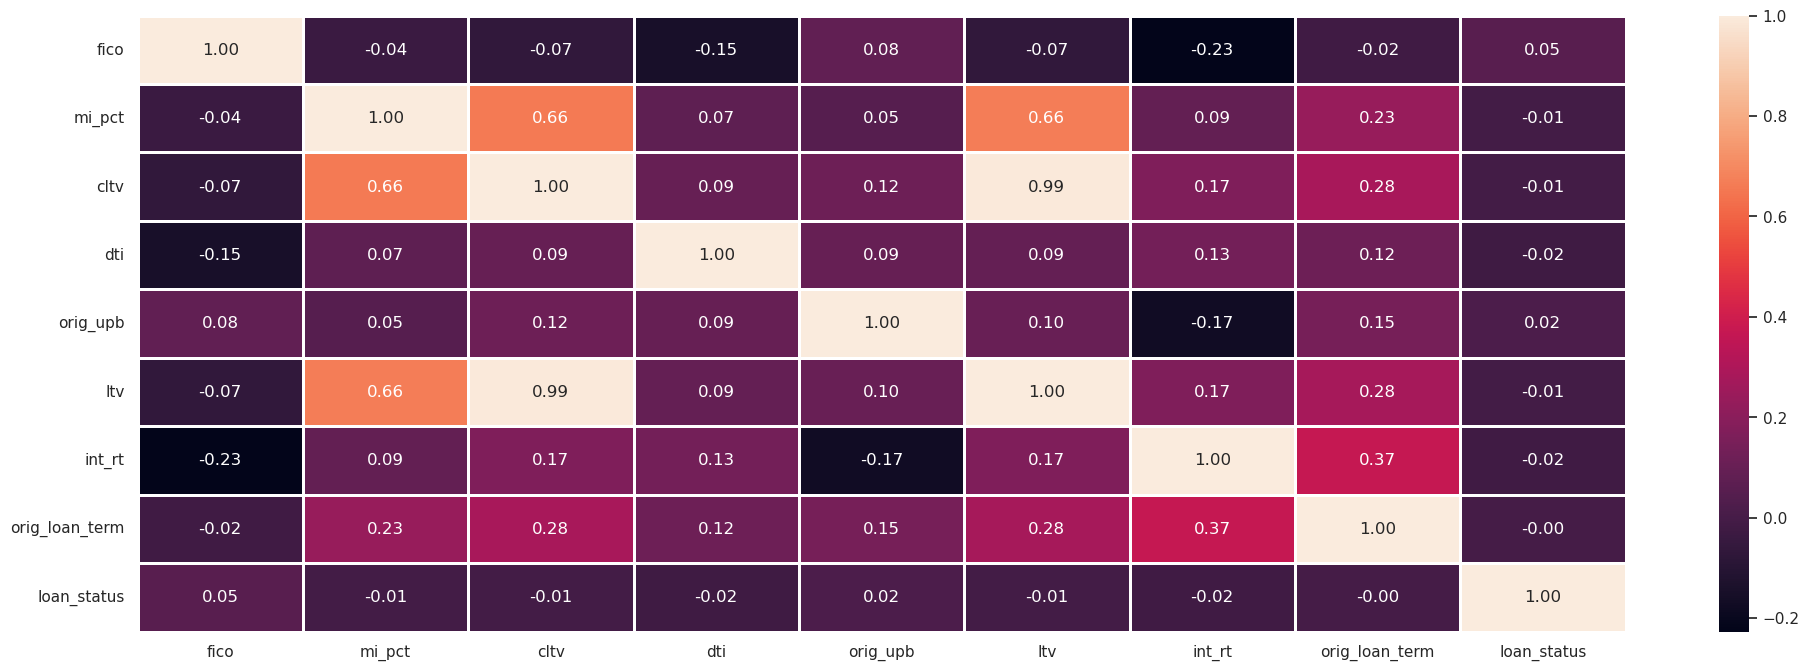

In [12]:
# Dataset without NA values
train_data_clean = train_data.dropna(subset=numerical_cols)

print("\nTable 3: Correlation Analysis With P-Values\n")
corr_cols = [col for col in numerical_cols if train_data_clean[col].nunique() > 5]

# List to store pairs of highly correlated features along with their p-values
high_corr_pairs = []
for i in range(len(corr_cols)):
    for j in range(i+1, len(corr_cols)):
        x = train_data_clean[corr_cols[i]]
        y = train_data_clean[corr_cols[j]]
        r, p_value = pearsonr(x, y)  # Computes Pearson correlation and p-value
        if abs(r) >= 0.4:
            high_corr_pairs.append((corr_cols[i], corr_cols[j], r, p_value))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation', 'P-Value'])
high_corr_df = high_corr_df.sort_values(by='Correlation', ascending=False)

print("Highly correlated feature pairs (|r| >= 0.4) with P-Values:")
if len(high_corr_df) > 0:
    display(high_corr_df)
else:
    print("No feature pairs with correlation >= 0.4 found.")

# Correlation Heatmap
sns.set(rc={'figure.figsize': (24, 8)})
sns.heatmap(data=train_data_clean.corr(numeric_only=True), annot=True, fmt=".2f", linewidths=2)
plt.show()

*Figure 2: Correlation heatmap of continuous variables in train_data.*

Following, Table 4 is comparing the mean values across the numerical features and loan status. The goal of this analysis is to determine whether there is a clear differentiation between loans that default and those that are fully paid based on key financial metrics.

In [13]:
print("\nTable 4: Mean Values Of Numerical Features By Loan Status\n")
# Compute mean values of each numeric feature, grouped by loan_status
feature_by_status = pd.DataFrame()
for col in numerical_cols:
    try:
        feature_by_status[col] = train_data_clean.groupby('loan_status')[col].mean()
    except:
        pass

display(feature_by_status)


Table 4: Mean Values Of Numerical Features By Loan Status



,fico,mi_pct,cltv,dti,orig_upb,ltv,int_rt,orig_loan_term
loan_status,,,,,,,,
0,717.900533,9.580817,78.561279,38.239787,229085.257549,78.250444,4.433309,334.188277
1,749.492721,7.822395,76.037697,35.188773,259992.260186,75.777801,4.281966,332.378058


Next, we created Q-Q plots (Figure 3) to test normality across numerical features. Most appear approximately linear, so no immediate transformations (like log or square-root) were applied before developing our initial models.

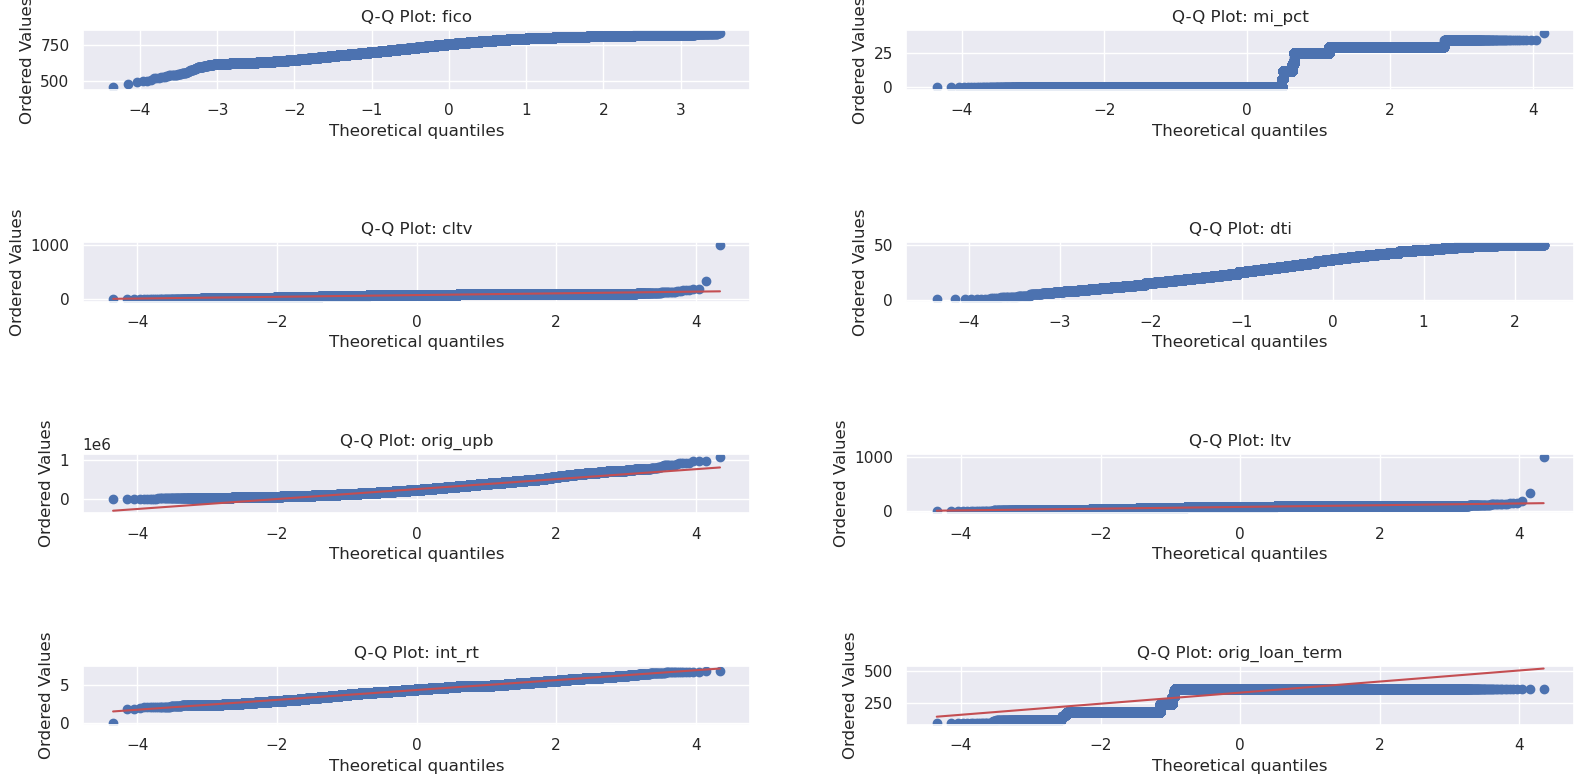

In [38]:
# Q-Q Plots for Normality Check
fig, axes = plt.subplots(4,2, figsize=(16,8))
axes = axes.flatten()
for i, feature in enumerate(numerical_cols):
    stats.probplot(train_data[feature], dist="norm", plot=axes[i])
    axes[i].set_title(f"Q-Q Plot: {feature}")

for j in range(len(numerical_cols), len(axes)):
    axes[j].axis("off")

plt.tight_layout(h_pad=5, w_pad=5)
plt.show()

*Figure 3: Q-Q plots indicating approximate normality for most continuous variables.*

Additionally, we present boxplots (Figure 4) to visualize potential outliers. While outliers are indeed present, we chose to keep them, believing they might represent meaningful cases or minority subgroups within the dataset. Removing them might erase valuable information, especially since they could represent cases of defaulted loans.

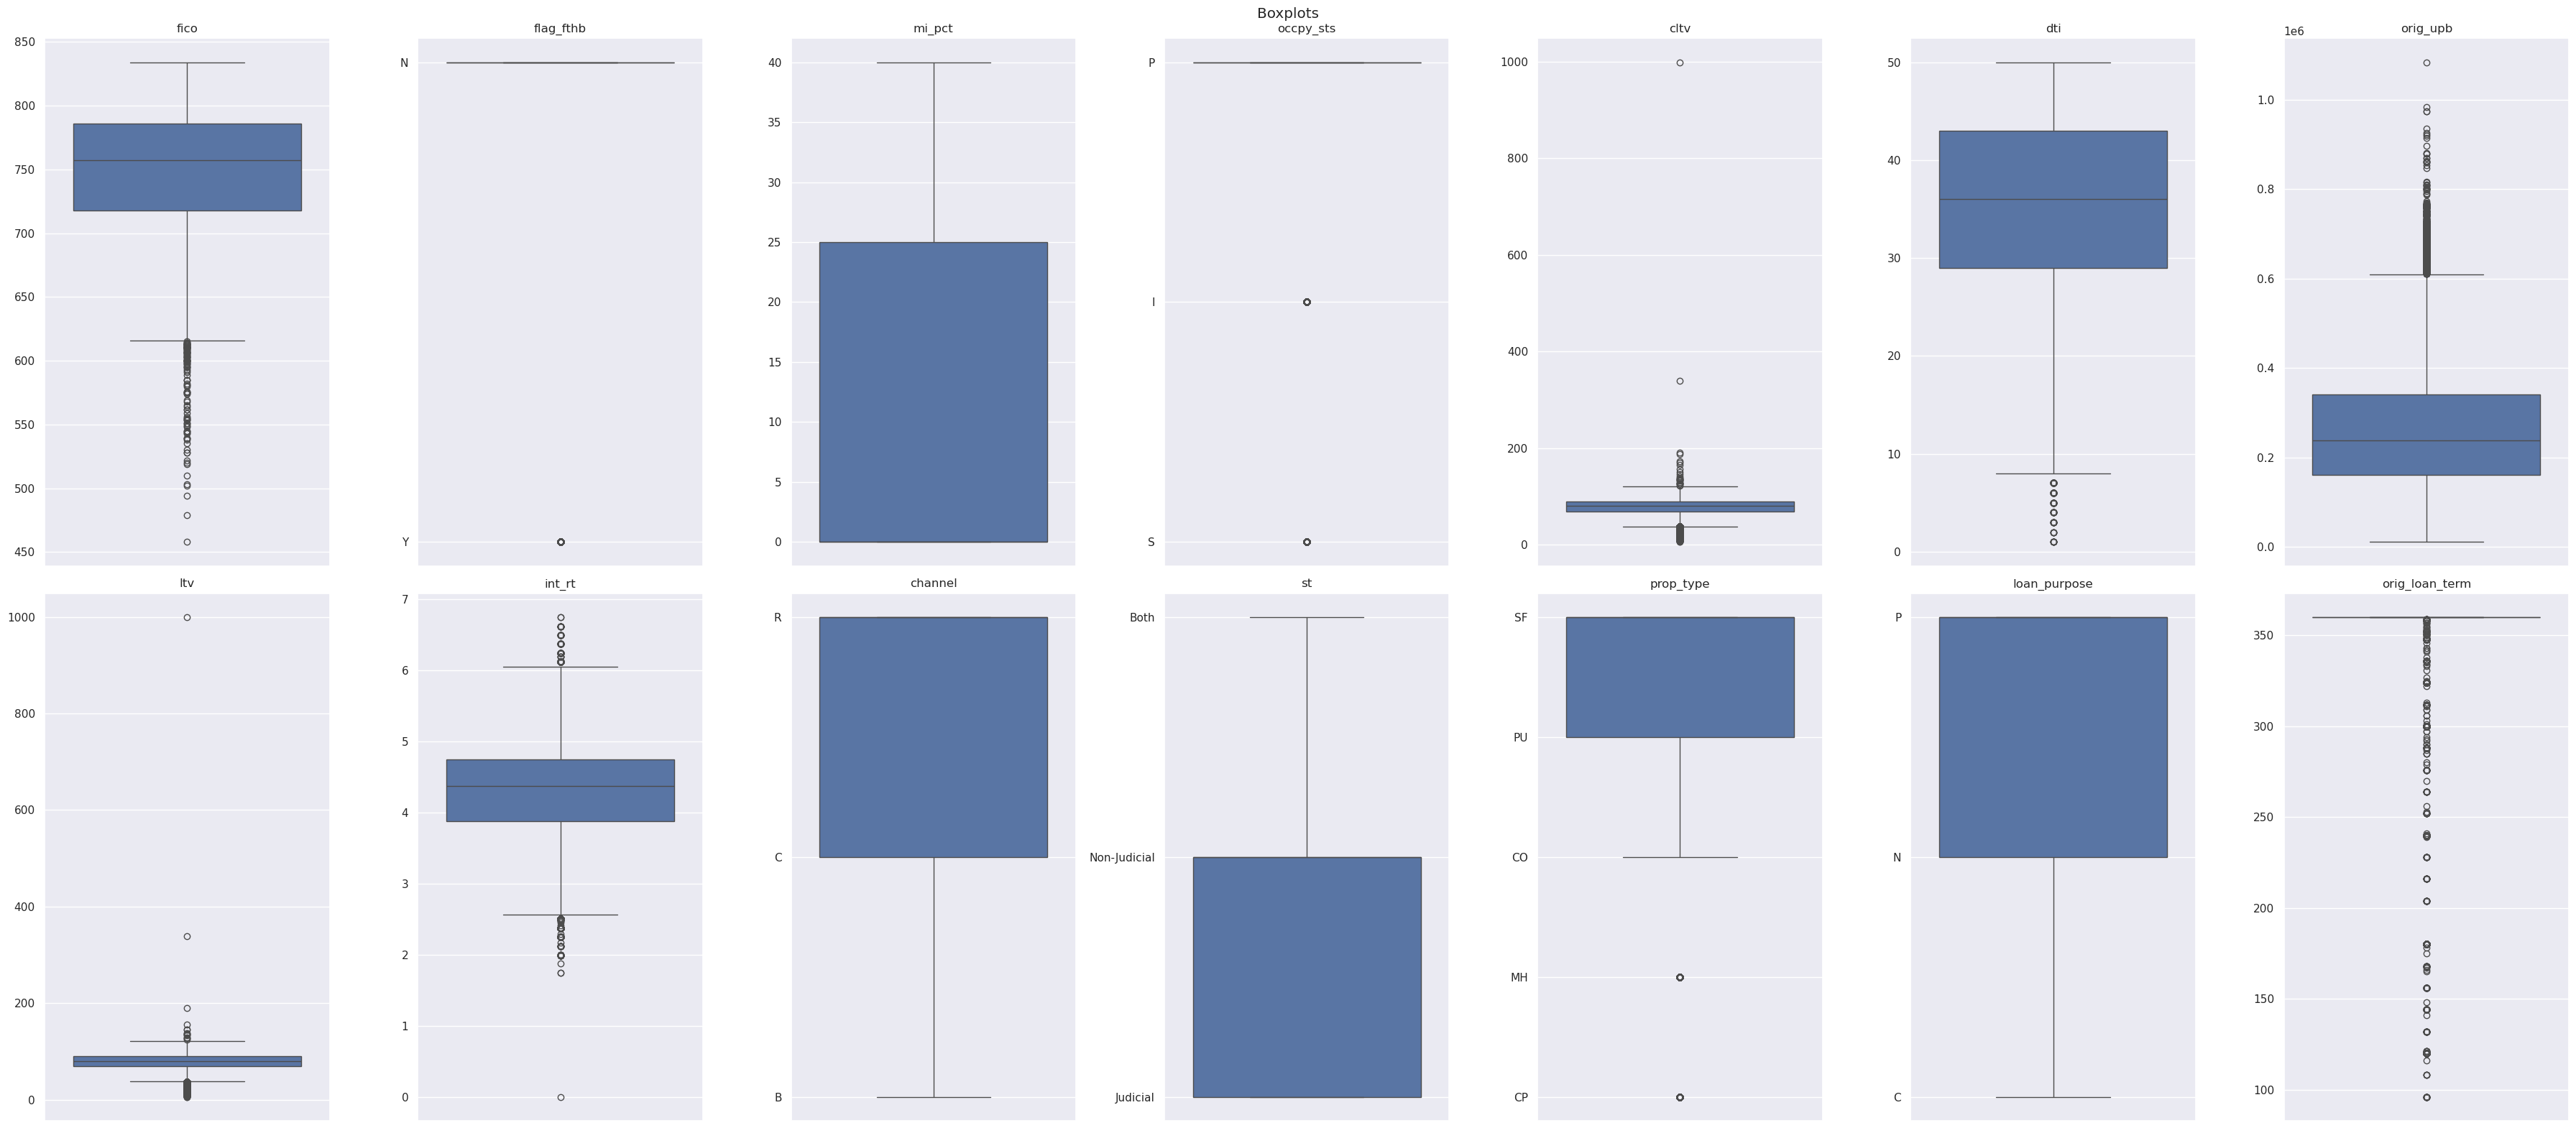

In [15]:
# Boxplots for Feature Distributions
fig, axes = plt.subplots(figsize=(36,16), ncols=X.shape[-1]//2, nrows=2, sharex=True)
axes = axes.flatten()
for i, ax in enumerate(axes):
    sns.boxplot(y=X_train.iloc[:, i], ax=ax)
    ax.set_title(X_train.columns[i])
    ax.set_ylabel("")
plt.suptitle("Boxplots")
plt.tight_layout()
plt.show()

*Figure 4: Boxplots revealing outliers in multiple variables.*

Finally, based on the above Exploratory Data Analysis, we have chosen to remove a final list of columns in hopes of improving generalization. As mentioned before, the correlation heatmaps showed a high correlation among CLTV, LTV, and MI_PCT. Thus, we decided to keep CLTV, as it reflects that CLTV (Combined Loan-to-Value) captures the total loan amount (including secondary financing) compared to the property’s appraised value, whereas LTV (Loan-to-Value) references only the original mortgage. On the other hand, MI_PCT was removed not only because of its high correlation with CLTV but also due to the skewness in its distribution, since most loans had zero loss coverage. Furthermore, orig_loan_term showed no significant differences when comparing mean values across defaulted versus paid loans, so it was also eliminated.

To conclude, these feature engineering steps were applied to both X_train and X_test, and the same transformations were applied to d_active_loans, a dataset containing only active loans. Once we have a working model, we plan to predict which and how many of these active loans are likely to default.

In [16]:
# Dropping columns after EDA
X_train = X_train.drop(["mi_pct","orig_loan_term","ltv"], axis=1)
X_test = X_test.drop(["mi_pct","orig_loan_term","ltv"], axis=1)

#Creating the active dataset that we would like to later applie our model, with the same feature engineering steps
d_active_loans = d[d['loan_status'] == 'active']
d_active_loans = d_active_loans.drop(["mi_pct", "orig_loan_term", "ltv"], axis=1)
d_active_loans = d_active_loans.drop(features_to_drop, axis=1)

Based on all the above data analysis, the foundation of our feature engineering can be broken down into two main parts: numerical and categorical preprocessing. First, we handle the numerical columns by imputing any empty cells with the median value of that column, using scikit-learn’s SimpleImputer. Notably, we enable the “add_indicator” parameter, which creates a separate feature indicating whether a given entry was imputed. This approach allows us to avoid discarding rows with missing values while ensuring that important information about missingness is retained. After imputation, the numerical features are standardized using StandardScaler, which subtracts the mean and divides by the standard deviation for each feature, bringing them to a common scale and helping prevent any single feature from dominating the model.

On the other hand, categorical variables are imputed with the most frequent category (again using SimpleImputer), then transformed via OneHotEncoder, which creates a binary (0/1) feature for each unique category. We employ the “handle_unknown='ignore'” setting to gracefully manage unforeseen categories in the test data.

Next, we apply a random undersampler to our entire feature set to address the significant imbalance in our data. This technique randomly selects samples from the majority class (fully paid loans) until the number of instances in both the default and fully paid categories is equal. Balancing the classes in this manner mitigates bias toward the dominant class and helps ensure that the model learns to distinguish between default and non-default loans more effectively.

By applying these pipelines to our classification task, we ensure that the model receives robust, well-structured input data. The imputation strategies help preserve as many data points as possible, while the scaling and encoding processes ensure that both numerical and categorical features are treated appropriately, mitigating issues such as differing scales or missing categories. Finally, the random sampler improves the imbalance of our data so the model is better able to predict the number of defaulted loans.

In [17]:
num_pre = Pipeline([
    ("num_impute", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])

cat_pre_full = Pipeline([
    ("num_impute", SimpleImputer(strategy="most_frequent")),
    ("cat_encode", OneHotEncoder(handle_unknown ="ignore"))
])

Under_Sampler = RandomUnderSampler(random_state=42)

In [18]:
# numeric vs. categorical columns in final pipeline

cat_col_positions = [1,2,7,8,9,10,11]
numerical_col_positions = [0,3,4,5,6]

# Model Fitting and Tuning

As we stated in the intoduction part of this report, the goal of our model is to predict whether a loan will end up being defaulted or be fully paid. This is based on the information provided by Freddie Mac and on our research. The data have been pre processed and different approaches have been considered to maximaze the predictive capabilities of our model. This is important since an accurate and interpretable model will aid in understanding the major contributers of loans that default, and will flag potiential high risk loans.

Thus, we initially explored a standard logistic regression (with and without regularization), Random Forest, Support Vectors and Neural Networks. After preliminary comparisons, we selected Random Forest due to its better performance in validation and its more interpretable nature. Below, we briefly describe the baseline model that is going to be used as a point of reference for our more advanced Random Forest model.

The baseline model is a $\ell_2$ regularization (ridge) logistic regression model with the basic feature engineering steps applied to all the model pipelines we tried. As mentioned before, there are three pre-processing steps that have been applied to give the model the best chance to perform well. We chose a logistic regression model with regularization to provide a point of reference, a model that lacks the more advance approaches but that can still deal with the high amount of features presented.

In [19]:
# Baseline logistic regression pipeline with regularization (L2)
reg_pipe_2 = ImPipeline([
    ("pre_processing", ColumnTransformer(
        [("num_pre", num_pre, numerical_col_positions),
        ("cat_pre_full", cat_pre_full, cat_col_positions),
        ])),
    ("sampler", Under_Sampler),
    ("model", LogisticRegression(random_state=42, penalty="l2", max_iter=1000))])

In [20]:
# Grid of possible C regularization values
C_list = np.linspace(0.01, 15, num=151)

# Set up GridSearchCV with multiple metrics (accuracy, f1, recall, precision)
log_rs = GridSearchCV(reg_pipe_2, 
                      param_grid={'model__C': C_list},
                      scoring = ["accuracy", "f1","recall","precision"],
                      cv = StratifiedKFold(n_splits=5, shuffle=True),
                      refit = "f1",
                      return_train_score = True)

# Train baseline model using grid search
baseline_model = log_rs.fit(X_train, y_train)
best_log_rs = baseline_model.best_estimator_

We systematically tuned the regularization strength by creating a grid of 𝐶 values (ranging from 0.01 to 15) and performed a StratifiedKFold cross-validation with five splits, ensuring each fold maintained the same default-to-non-default ratio as the overall dataset. We evaluated several metrics, including accuracy, F1, recall, and precision, and chose accuracy as our primary criterion for refitting. The best set of hyperparameters was selected based on cross-validation results, yielding a baseline metric against which we could compare more advanced models.

In [21]:
# Classification report for baseline model (train vs. test)
Train_report = classification_report(
    y_train, 
    best_log_rs.predict(X_train), 
    target_names=['Default', 'Non Default']
)
print("Table 5: Train Data Classification Report\n")
print(Train_report)

Test_report = classification_report(
    y_test, 
    best_log_rs.predict(X_test), 
    target_names=['Default', 'Non Default']
)
print("Table 6: Test Data Classification Report\n")
print(Test_report)

Table 5: Train Data Classification Report

              precision    recall  f1-score   support

     Default       0.01      0.70      0.03       597
 Non Default       1.00      0.69      0.81    100767

    accuracy                           0.69    101364
   macro avg       0.51      0.69      0.42    101364
weighted avg       0.99      0.69      0.81    101364

Table 6: Test Data Classification Report

              precision    recall  f1-score   support

     Default       0.01      0.63      0.02       149
 Non Default       1.00      0.69      0.82     25192

    accuracy                           0.69     25341
   macro avg       0.50      0.66      0.42     25341
weighted avg       0.99      0.69      0.81     25341



The above metrics show the baseline model’s real-world performance, with the similarity between training and test performance suggesting that the model is generalizing reasonably well and is not heavily overfitting. The model’s overall accuracy is 69%, accompanied by an F1-score for default loans of 0.03, a precision of 0.01, and a recall of 0.70. The confusion matrix below shows 95 true positives, 54 false negatives, and 7808 false positives, highlighting areas for improvement in detecting default loans.

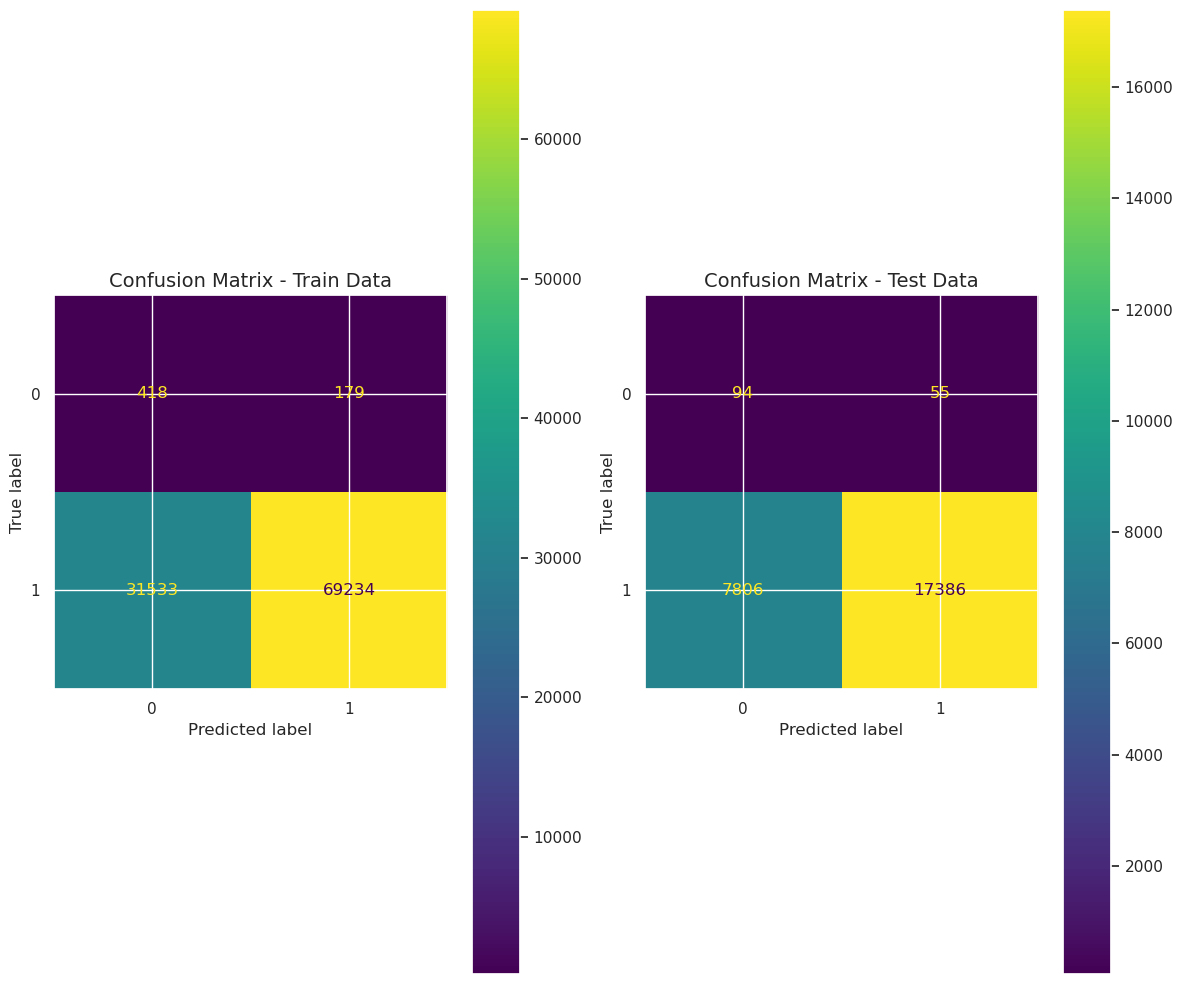

In [22]:
# Confusion matrices for baseline model (train & test)
fig, ax = plt.subplots(1, 2, figsize=(12, 10))

# Plot the confusion matrix for training data
ConfusionMatrixDisplay.from_estimator(best_log_rs, X_train, y_train, ax=ax[0])
ax[0].set_title("Confusion Matrix - Train Data", fontsize=14)
# Plot the confusion matrix for test data
ConfusionMatrixDisplay.from_estimator(best_log_rs, X_test, y_test, ax=ax[1])
ax[1].set_title("Confusion Matrix - Test Data", fontsize=14)

plt.tight_layout()
plt.show()

*Figure 5: Confusion Metrix of the Baseline Model*

Moving to the final model choice, it was mainly inspired by several reasons, first, after running cross-validation, Random Forest consistently outperformed the other models (Logistic Regression and Support Vector Machines) in identifying defaulted loans. It also manages noisy data and imbalanced classes effectively, reducing the risk of overfitting in a dataset with high imbalance. A key requirement was interpretability, which Random Forest addresses via feature importance measures, an aspect where it offers more transparency than many other algorithms. While Support Vector Machines also performed well, their decision boundary can be harder to interpret, especially without kernel-specific feature insights. Neural networks were excluded from consideration due to their “black box” nature; although powerful, they tend to lack the transparency we need for critical lending decisions.

In [23]:
# Advanced model pipeline: Random Forest with same preprocessing & under-sampling
Random_Forest = ImPipeline([
    ("pre_processing", ColumnTransformer(
        [("num_pre", num_pre, numerical_col_positions),
            ("cat_pre_full", cat_pre_full, cat_col_positions)]
    )),
    ("sampler", Under_Sampler),
    ("model", RandomForestClassifier(random_state=42, n_jobs=-1)
    )
])

The above code depicts the model pipeline used to construct our final Random Forest model. As mentioned in the feature engineering and baseline model sections, all models have had three main preprocessing steps that use the ColumnTransformer from the scikit-learn library. This transformer applies the subsequent steps to the relevant columns in the data, whether training or test, ensuring that there is no leakage between them. It applies numerical imputation to any missing continuous values using the median of each column, as we believed this would be the best approach without skewing columns that had a substantial number of missing values. The alternative, dropping rows with missing data, would have resulted in losing valuable information. Next, for categorical features, we used one-hot encoding, which created multiple columns as previously mentioned, and the final sampler step were random under sampling is applyied to the data so we can deal with imbalance. These features are then supplied into our Random Forest model to predict if a loan will default ot not.

To optimize our Random Forest model, we conducted a grid search over several key parameters, using a StratifiedKFold 5-fold cross-validation to maintain the original class distribution in each fold. Specifically, we tuned:

- n_estimators (the number of trees in the forest),

- max_features (the subset of features considered for splitting at each node),

- max_depth (the maximum depth allowed for each tree).

By systematically evaluating every combination of these parameter values, our primary objective was to maximize the F1 score, striking a balance between precision and recall. We monitored additional metrics (accuracy, recall, and precision) but used F1 as the “refit” metric to identify the best compromise between identifying default loans and limiting false alarms. This approach also helps maintain model interpretability, which is essential for understanding how different features contribute to the prediction of default risk.

In [43]:
# Grid for Random Forest hyperparameters
param_grid = {
    "model__n_estimators": [800, 1000, 1200],
    "model__max_features": ["sqrt"],
    "model__max_depth": [2, 5, 10]
}
# GridSearchCV setup for Random Forest with multiple metrics
Best_Random = GridSearchCV(
    estimator=Random_Forest,
    param_grid=param_grid,
    scoring = ["accuracy", "f1","recall","precision"],
    refit= "f1",
    cv = StratifiedKFold(n_splits=5, shuffle=True),
    n_jobs=-1,
)

# Fit the Random Forest via grid search
Advance_model = Best_Random.fit(X_train, y_train)
best_model_random = Advance_model.best_estimator_

print(f"Best combination of parameters that achived the highest f1 score: {Best_Random.best_params_}")

Best combination of parameters that achived the highest f1 score: {'model__max_depth': 2, 'model__max_features': 'sqrt', 'model__n_estimators': 800}


Subsequently, we created a grid of possible values for n_estimators, max_features and max_depth, then passed this grid to GridSearchCV, specifying each parameter with the prefix model__ to indicate that our Random Forest classifier is the “model” step in the pipeline. GridSearchCV systematically iterated over each combination of these parameters, training a new Random Forest model each time. Ultimately, it identified the parameter set that achieved the highest cross-validated F1 score, which we then selected as our optimal configuration.

The StratifiedKFold(n_splits=5, shuffle=True) cross-validation strategy was used to preserve class distribution in each fold. In each iteration, the data is split into training and validation subsets, and the model is fitted on four folds and evaluated on the remaining fold. This is repeated five times each with a different fold serving as the validation set. By averaging performance across these five folds, we obtain a robust estimate of the model’s generalizability. The dictionary in param_grid instructs scikit-learn to explore each parameter combination and choose the best one based on the cross-validated F1 metric.

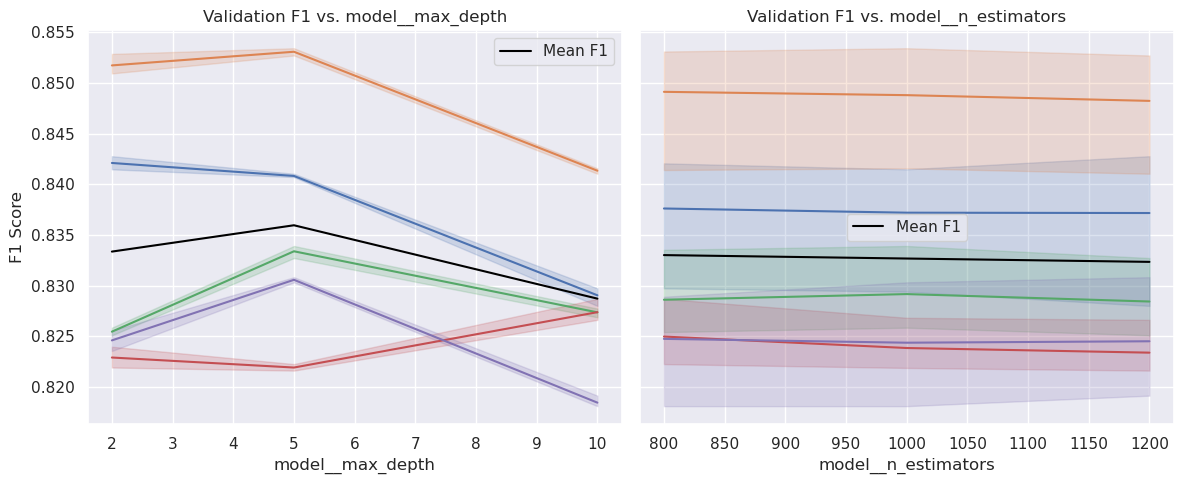

In [25]:
# Convert the grid search results to a DataFrame to examine
cv_results = pd.DataFrame(Best_Random.cv_results_)

# Focus on folds' F1 scores
cv_md = cv_results.filter(regex=r'(split[0-4]_test_f1|mean_test_f1)').copy()
cv_md = cv_md.assign(max_depth=cv_results['param_model__max_depth'])
d_md = cv_md.melt(
    id_vars=('max_depth', 'mean_test_f1'),
    var_name='fold',
    value_name='F1'
)


cv_ne = cv_results.filter(regex=r'(split[0-4]_test_f1|mean_test_f1)').copy()
cv_ne = cv_ne.assign(n_estimators=cv_results['param_model__n_estimators'])

d_ne = cv_ne.melt(
    id_vars=('n_estimators', 'mean_test_f1'),
    var_name='fold',
    value_name='F1'
)

# Plot F1 vs. max_depth and n_estimators
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.lineplot(x='max_depth', y='F1', data=d_md, color='black', errorbar=None, ax=axes[0], label='Mean F1')
sns.lineplot(x='max_depth', y='F1', hue='fold', data=d_md, ax=axes[0], legend=False)
axes[0].set_title("Validation F1 vs. model__max_depth")
axes[0].set_xlabel("model__max_depth")
axes[0].set_ylabel("F1 Score")


sns.lineplot(x='n_estimators', y='F1', data=d_ne, color='black', errorbar=None, ax=axes[1], label='Mean F1')
sns.lineplot(x='n_estimators', y='F1', hue='fold', data=d_ne, ax=axes[1], legend=False)
axes[1].set_title("Validation F1 vs. model__n_estimators")
axes[1].set_xlabel("model__n_estimators")
axes[1].set_ylabel("F1 Score")

plt.tight_layout()
plt.show()

*Figure 6: F1 Solution Path for max_depth and n_estimator parameters*

Visualising from what we were explaining before, Figure 6 shows how F1 changes as estimators and max_depth increases. The black curve shows the overall (mean) F1 across all folds at each step while the colored lines represent the individual folds, ilustrating variance between splits, with different folds responding slightly differently, but the overall mean (black line) typically has a clear minimum region. The best n_estimators and max_depth found by GridSearchCV is where the average f1 is the highest. Thus, we conclude that GridSearchCV + 5-fold cross-validation not only provides an optimal hyperparameter for our Random Forest model but also offers insight into how the model’s predictive performance changes across different amounts of estimators.

In [26]:
# Classification reports (train vs. test) for best Random Forest model
Train_report = classification_report(
    y_train, 
    best_model_random.predict(X_train), 
    target_names=['Default', 'Non Default']
)
print("Table 7: Train Data Classification Report\n")
print(Train_report)

Test_report = classification_report(
    y_test, 
    best_model_random.predict(X_test), 
    target_names=['Default', 'Non Default']
)
print("Table 8: Test Data Classification Report\n")
print(Test_report)

Table 7: Train Data Classification Report

              precision    recall  f1-score   support

     Default       0.02      0.69      0.03       597
 Non Default       1.00      0.73      0.85    100767

    accuracy                           0.73    101364
   macro avg       0.51      0.71      0.44    101364
weighted avg       0.99      0.73      0.84    101364

Table 8: Test Data Classification Report

              precision    recall  f1-score   support

     Default       0.01      0.64      0.03       149
 Non Default       1.00      0.73      0.85     25192

    accuracy                           0.73     25341
   macro avg       0.51      0.69      0.44     25341
weighted avg       0.99      0.73      0.84     25341



Above and below, the results reveal that our improved model maintains the same number of true positives (95) as the baseline but reduces false positives by approximately 1,200 cases, thereby increasing overall accuracy. As shown in Table 7 and Table 8, the accuracy reaches 73% on the test set, reflecting a notable improvement in distinguishing genuine default loans from non-defaults. Despite the low precision for the default class, the relatively higher recall (0.64) indicates that the model captures more potential defaults than before an important consideration in lending decisions. Although these metrics have room for growth (particularly in raising precision), the significant reduction in false positives mitigates the potentially high cost of incorrectly classifying non-default loans, thus steering the model toward a more practical balance between risk management and classification accuracy.

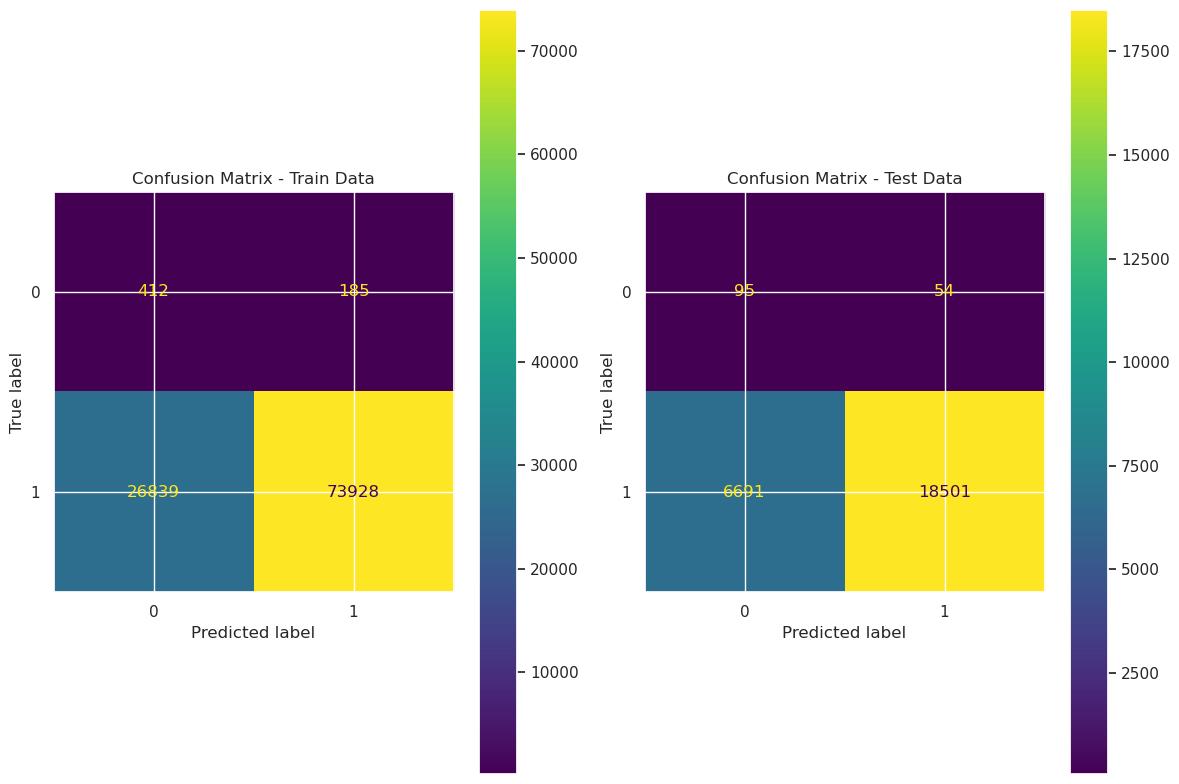

In [27]:
# Confusion matrices for the Random Forest model (train & test)
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# Plot the confusion matrix for training data
ConfusionMatrixDisplay.from_estimator(best_model_random, X_train, y_train, ax=ax[0])
ax[0].set_title("Confusion Matrix - Train Data")
# Plot the confusion matrix for test data
ConfusionMatrixDisplay.from_estimator(best_model_random, X_test, y_test, ax=ax[1])
ax[1].set_title("Confusion Matrix - Test Data")

plt.tight_layout()
plt.show()

*Figure 7: Confusion Metrix of the Advance Model Model*

Below, this snippet compares our two models the baseline and one advanced Random Forest by plotting both their ROC (Receiver Operating Characteristic) curves. It demonstrates how each model’s probabilities are used to calculate key the ROC performance metric, which are then visualized side by side:

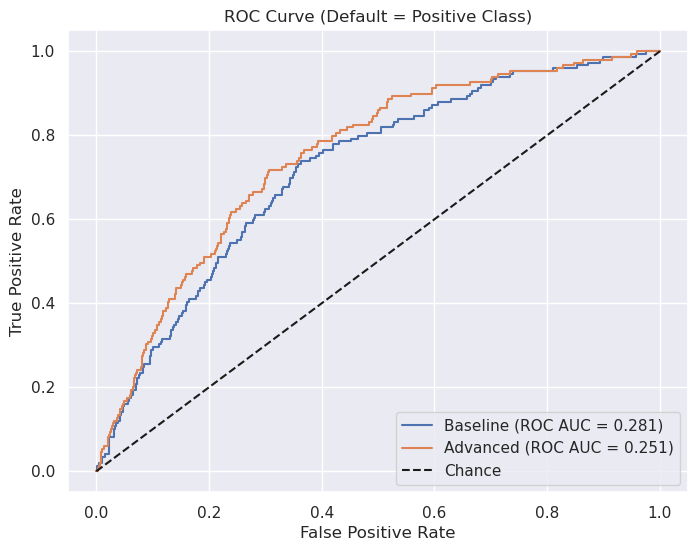

In [36]:
# Probability predictions for class 0 (Default)
y_pred_proba_baseline = best_log_rs.predict_proba(X_test)[:, 0]
y_pred_proba_advanced = best_model_random.predict_proba(X_test)[:, 0]

# Compute ROC metrics for the baseline model
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline, pos_label=0)
roc_auc_baseline = roc_auc_score(y_test, y_pred_proba_baseline)

# Compute ROC metrics for the advanced model
fpr_advanced, tpr_advanced, _ = roc_curve(y_test, y_pred_proba_advanced, pos_label=0)
roc_auc_advanced = roc_auc_score(y_test, y_pred_proba_advanced)

# Plot ROC curves for both models
plt.figure(figsize=(8, 6))
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline (ROC AUC = {roc_auc_baseline:.3f})')
plt.plot(fpr_advanced, tpr_advanced, label=f'Advanced (ROC AUC = {roc_auc_advanced:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Default = Positive Class)')
plt.legend(loc='lower right')
plt.show()

*Figure 8: ROC Curve Comparison Between The Baseline and Advance Model*

In Figure 8, the ROC values for both models fall below 0.5 largely because the labeling has been inverted to treat “default” (class 0) as the positive class, whereas the models were originally set up to predict “paid” as positive. Despite the inversion, both models exhibit similar ROC performance—with the Baseline model showing a slightly higher ROC AUC under this framing.

Next, to examine which features had the highest impact, we extract the feature importance from the "feature_importances_" parameter of our Random Forest model:

Table 9: Top 10 Key Factors Affecting Loan Default Risk
num_pre__fico                     0.308838
num_pre__orig_upb                 0.121180
num_pre__int_rt                   0.119769
num_pre__dti                      0.086008
num_pre__cltv                     0.080135
cat_pre_full__property_val_3.0    0.042174
cat_pre_full__st_Judicial         0.027788
cat_pre_full__property_val_1.0    0.026583
cat_pre_full__st_Non-Judicial     0.019455
cat_pre_full__prop_type_PU        0.018806
dtype: float64


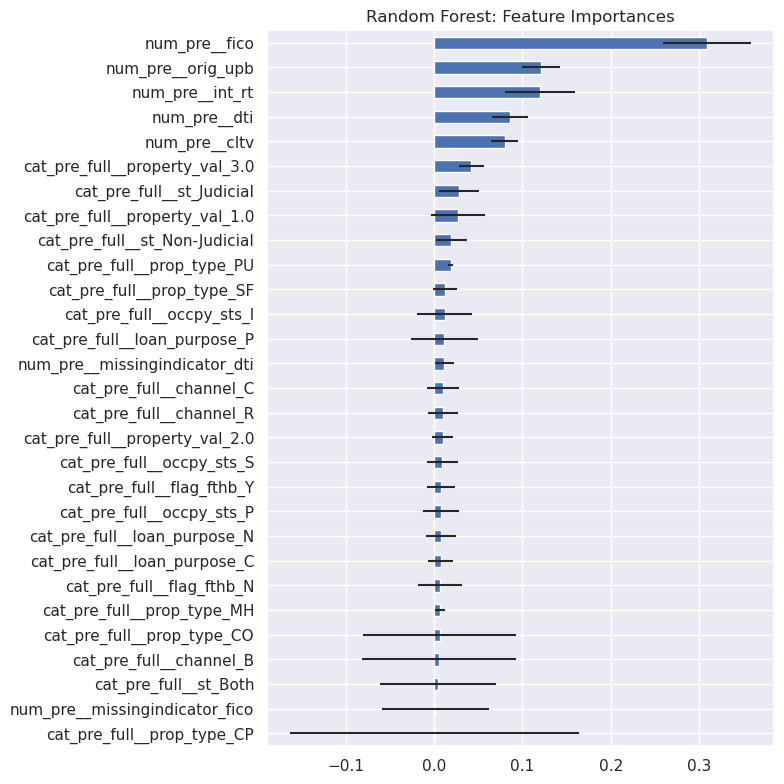

In [29]:
# Extract and plot feature importances from the best Random Forest model
model = best_model_random.named_steps["model"]
feature_names = best_model_random.named_steps["pre_processing"].get_feature_names_out()

# Standard deviation of feature importances across all trees
std = np.std([tree.feature_importances_ for tree in best_model_random["model"].estimators_], axis=0)

# Sort feature importances in ascending order
importances_rf = pd.Series(best_model_random["model"].feature_importances_, index=feature_names).sort_values(ascending=True)

# Plot the feature importances
plt.figure(figsize=(8, 8))
ax = importances_rf.plot.barh(xerr=std)
ax.set_title("Random Forest: Feature Importances")
ax.figure.tight_layout()

print("Table 9: Top 10 Key Factors Affecting Loan Default Risk")
print(importances_rf.sort_values(ascending=False).head(10))

*Figure 9: Random Forest Feature Importances*

The figure above (Figure 9) illustrates the feature importances from our final Random Forest model. Each horizontal bar represents the mean contribution of a given feature across all decision trees in the ensemble, while the error bars (xerr) indicate the standard deviation of these contributions. Features toward the right (larger bar) have a greater impact on the model’s classification of default versus non-default loans, whereas those closer to the left play a relatively smaller role. 

# Active Loans Risk Assessment

Below is a concise recap of our process for predicting risk on the active loans dataset. First, we used our trained Random Forest model to estimate each loan’s probability of default. Next, we applied predefined thresholds to classify those probabilities into three categories:

- Low Risk: Probability of default < 0.05

- Medium Risk: Probability of default < 0.30

- High Risk: Probability of default ≥ 0.30

Finally, we aggregated the results to see how many loans fell into each category, helping us pinpoint those that pose the greatest potential risk. This allows Freddie Mac to prioritize monitoring and intervention for the highest-risk loans.

Distribution of Default Risk Among Active Loans:
               Count  Percentage
risk_category                   
High Risk      66878   91.244969
Medium Risk     6417    8.755031


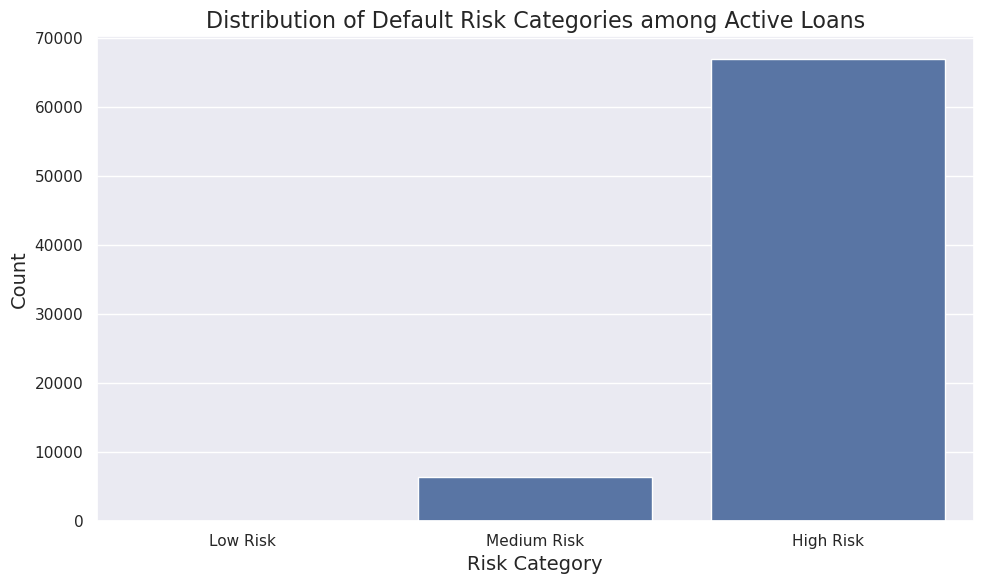

In [30]:
active_loans = d_active_loans.copy()
active_loans['default_probability'] = best_model_random.predict_proba(active_loans)[:, 0]

# Define risk categories based on the probability thresholds
def assign_risk_category(prob):
    if prob < 0.05:
        return 'Low Risk'
    elif prob < 0.30:
        return 'Medium Risk'
    else:
        return 'High Risk'

active_loans['risk_category'] = active_loans['default_probability'].apply(assign_risk_category)

#Print out the distribution of risk categories
risk_counts = active_loans['risk_category'].value_counts()
risk_percents = active_loans['risk_category'].value_counts(normalize=True) * 100
risk_df = pd.DataFrame({'Count': risk_counts, 'Percentage': risk_percents})

print("Distribution of Default Risk Among Active Loans:")
print(risk_df)

#Plot the distribution of default risk categories among active loans
plt.figure(figsize=(10, 6))
sns.countplot(
    data=active_loans, 
    x='risk_category', 
    order=['Low Risk', 'Medium Risk', 'High Risk']
)
plt.title('Distribution of Default Risk Categories among Active Loans', fontsize=16)
plt.xlabel('Risk Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()
plt.show()

# Discussion & Conclusions

Our final Random Forest model achieved a notable improvement in predicting whether a loan would default or be fully paid off when compared to the baseline Logistic Regression and Support Vector Machine approaches. Specifically, it demonstrated an accuracy of approximately 73% on the test set, with a significant reduction in false positive default loans. In practical terms, it identified more true defaults than the baseline while simultaneously reducing false positive identified loans by around 1,200. This balance between capturing genuine defaults and avoiding undue misclassifications is especially important in the lending industry, as it helps mitigate financial loss and supports more informed risk management.

A key advantage of this Random Forest lies in its ability to offer interpretable insights through feature importances. As shown in Figure 9 and Table 9, loan characteristics such as fico, orig_upb, int_rt, dti, and cltv consistently emerged as the strongest predictors. Higher credit scores (fico) generally signaled lower default risk, while loans with larger principal balances (orig_upb) or higher interest rates (int_rt) posed a greater threat of default, aligning with established industry understanding. In addition, we found that debt to income ratio (dti) and combined loan to value (cltv) were pivotal in discriminating higher risk borrowers, underscoring the roles of borrower capacity and home equity in loan performance. An honorable mention goes to “cat_pre_full__st_Judicial,” which identifies states with judicial foreclosure laws requiring a court hearing and a judge’s order to approve the foreclosure process. This highlights the potential for further improving the model’s predictive capabilities by incorporating additional external data related to regional legal frameworks.

From a real-world perspective, lenders can use these findings to refine underwriting processes, prioritize at-risk loans for early intervention, and communicate key risk factors to regulators and stakeholders in a transparent manner. By applying thresholds to the model’s probabilities of default, we classified active loans into Low, Medium, and High risk categories, allowing Freddie Mac to allocate resources more efficiently. Loans flagged as High Risk warrant closer monitoring or enhanced servicing strategies aimed at preventing default, potentially reducing losses for both the lender and the borrower.

Despite these positive outcomes, caution is advised when interpreting the results. First, the model though robust still exhibits relatively low precision for defaulted loans, meaning it incorrectly flags some non-default loans as likely defaults. This imprecision can lead to unnecessary interventions or elevated costs. Second, while the Random Forest provides more transparency than some black box methods (e.g., neural networks), it remains an ensemble of decision trees whose interactions are not as straightforward to parse as simpler models. Furthermore, the dataset may not perfectly represent all borrower demographics or economic conditions, introducing uncertainty about how well the findings would generalize to different markets or time frames. Future research could address these limitations by incorporating more granular data (e.g., macroeconomic indicators, borrower behavior over time) or by tailoring the information to represent specific geographical locations better. I beleve a substantial improvement could be achieved by incorporating the geographic context of the loan, such as whether it is located in a high cost urban area or a more affordable region. Although some location data are available, cross referencing it with loan amounts and borrower salaries may provide deeper insights. Large cities, for instance, typically have higher living costs and inflation turnover, which can significantly influence a borrower’s default risk factors not fully captured in the current model.

Overall, this model delivers a practical and interpretable solution for Freddie Mac, offering clear benefits over the baseline approach in managing default risk. By highlighting the most influential features, it enables targeted strategies to reduce loan losses and meet regulatory expectations for transparency. In the future, extending the model to include broader variables and validating it across diverse cohorts would bolster its reliability. Nonetheless, as it stands, our Random Forest framework provides a strong foundation for risk assessment and a scalable avenue for continued improvement in mortgage default prediction.

# Generative AI statement

Generative AI was used for generating explanations for error messages and debugging, providing hints or suggestions to improve code, enhancing visualizations and the quality of the report.

# References

In [44]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf ICA_2.ipynb

[NbConvertApp] Converting notebook ICA_2.ipynb to pdf
[NbConvertApp] Support files will be in ICA_2_files/
[NbConvertApp] Making directory ./ICA_2_files
[NbConvertApp] Writing 126375 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 827455 bytes to ICA_2.pdf
